# Подготовка данных и оценка инвестиционной привлекательности

## Импорты и функции

In [27]:
!pip install xgboost lightgbm shap prophet
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from prophet import Prophet
from IPython.display import FileLink

# Функция для поиска выбросов и подсчёта их количества по регионам
def count_outliers_by_region(df, year_columns):
    region_outlier_count = {}
    total_outliers = 0
    for indicator in df["Показатель"].unique():
        df_subset = df[df["Показатель"] == indicator]
        for col in year_columns:
            Q1 = df_subset[col].quantile(0.25)
            Q3 = df_subset[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 2 * IQR
            upper_bound = Q3 + 2 * IQR
            outliers = df_subset[(df_subset[col] < lower_bound) | (df_subset[col] > upper_bound)]
            total_outliers += len(outliers)
            for region in outliers["Регион"]:
                region_outlier_count[region] = region_outlier_count.get(region, 0) + 1
    return total_outliers, region_outlier_count

# Функция для очистки имён столбцов от спецсимволов
def clean_column_names(df):
    df.columns = df.columns.str.replace(r"[^\w\d_]", "_", regex=True)
    return df

# Функция для подготовки данных (pivot-таблица) с исключением целевого показателя
def prepare_data(df, target_to_exclude, year_column):
    features = df[df["Показатель"] != target_to_exclude]
    return features.pivot(index="Регион", columns="Показатель", values=year_column)

# Функции для расчёта метрик ошибок:

# SMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10 # Для предотвращения деления на ноль к действительному значению добавляется очень маленькое число
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon))

# Функция для расчёта сразу всех метрик ошибок
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, smape

# Функция для обучения и оценки одной модели
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return calculate_metrics(y_test, y_pred)

# Функция для прогнозирования одного временного ряда с помощью Prophet
def forecast_series(df_group, periods=5): # periods это количество лет для прогноза
    # Из данных выбираются только столбцы с годом и значением фактора
    df_prophet = df_group[["Год", "Значение"]].copy()
    # Год преобразуется в дату и столбец переименовывается в "ds" (такие условия работы библиотеки)
    df_prophet["ds"] = pd.to_datetime(df_prophet["Год"].astype(str) + "-12-31")
    # Также условием библиотеки является, что столбец со значениями должен называться "y"
    df_prophet.rename(columns={"Значение": "y"}, inplace=True)
    # Данные сортируются в хронологическом порядке
    df_prophet = df_prophet.sort_values("ds")

    # Учитывается годовая сезонность
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_prophet[["ds", "y"]])
    
    # Задаются даты для прогнозирования с годовой разницей
    future = model.make_future_dataframe(periods=periods, freq='YS')
    # Модель строит прогнозы
    forecast = model.predict(future)
    
    # Фильтрация прогнозных значений на будущие даты
    forecast = forecast[forecast["ds"] > df_prophet["ds"].max()]
    forecast["Год"] = forecast["ds"].dt.year
    # Prophet изначально требует определённые названия столбцов, но для удобства они сразу же переименовываются
    result = forecast[["ds", "Год", "yhat", "yhat_lower", "yhat_upper"]].rename(
    columns={
        "ds": "Дата",
        "yhat": "Прогноз",
        "yhat_lower": "Нижняя граница",
        "yhat_upper": "Верхняя граница"})
    return result

# Функция для агрегирования годовых признаков 
def aggregate_years(X):
    df = X.copy()
    base = [c.rsplit("_",1)[0] for c in df.columns] # Разделяются названия факторов, так как они занесены как {Фактор_Год}
    agg = {}
    for b in set(base):
        cols = [c for c in df.columns if c.startswith(b+"_")]
        agg[b] = df[cols].mean(axis=1) # Рассчитывается среднее значение по годам
    return pd.DataFrame(agg, index=df.index)

## Подготовка данных

In [2]:
# Загружается Excel-файл
xls = pd.ExcelFile("Факторы ИПР.xlsx")

# Обрабатывается каждый лист
all_sheets = []
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name, skiprows=1)  # Пропускается первая строка с названием показателя
    indicator_name = pd.read_excel(xls, sheet_name=sheet_name, nrows=1).columns[0]  # Название показателя заносится в переменную
    df.rename(columns={df.columns[0]: "Регион"}, inplace=True)
    df["Показатель"] = indicator_name
    all_sheets.append(df)

# Объединение всех листов и корректировка названий столбцов
df_wide = pd.concat(all_sheets, ignore_index=True)
df_wide.columns = df_wide.columns.map(str)

# Приведение данных к числовому виду
year_columns = [col for col in df_wide.columns if col.isdigit()]
for col in year_columns:
    df_wide[col] = (
        df_wide[col]
        .astype(str)
        .str.replace("\xa0", "")  # неразрывный пробел
        .str.replace(r"[\xa0\s]+", "", regex=True)
        .str.replace(",", ".")
        .astype(float)
    )

# Заполнение пропусков методом KNN 
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="distance")
df_wide[year_columns] = imputer.fit_transform(df_wide[year_columns])

# Подсчёт выбросов
total_outliers, outlier_counts = count_outliers_by_region(df_wide, year_columns)
print(f"Общее количество выбросов в наборе данных: {total_outliers}")
print("Количество выбросов по каждому региону:")
for region, count in sorted(outlier_counts.items(), key=lambda x: -x[1]):
    print(f"{region}: {count}")

# Логарифмизация данных
df_l = df_wide.copy()
for col in year_columns:
    df_l[col] = np.where(df_l[col] > 0, np.log1p(df_l[col]), df_l[col])

# Подсчёт количества бесконечных значений для каждого столбца для проверки корректности итоговых данных
infinite_counts = {}
for col in year_columns:
    count_inf = ((df_l[col] == np.inf) | (df_l[col] == -np.inf)).sum()
    infinite_counts[col] = count_inf

print("Количество бесконечных значений в каждом столбце:")
for col, count in infinite_counts.items():
    print(f"{col}: {count}")

# Сохранение обработанного файла
df_l.to_excel("Обработанные данные.xlsx", index=False)

# Вывод ссылки для скачивания
FileLink("Обработанные данные.xlsx")

Общее количество выбросов в наборе данных: 1147
Количество выбросов по каждому региону:
г.Санкт-Петербург: 634
Ленинградская область: 202
  в т.ч. Ненецкий авт. округ: 186
Калининградская область: 39
Вологодская область: 32
Мурманская область: 24
Республика Коми: 11
Республика Карелия: 9
Новгородская область: 4
  Архангельская область без Ненецкого авт.округа: 3
Псковская область: 3
Количество бесконечных значений в каждом столбце:
2010: 0
2011: 0
2012: 0
2013: 0
2014: 0
2015: 0
2016: 0
2017: 0
2018: 0
2019: 0
2020: 0
2021: 0
2022: 0


C:\Users\nikid\Обработанные данные.xlsx

## Выбор модели МО перед SHAP-анализом для 2022 г.

In [3]:
# Определяются целевые переменные и фиксируется 2022 год для анализа
target_1 = "Инвестиции в основной капитал, млн руб" # Далее - ИвОК
target_2 = "Инвестиции в основной капитал на душу населения, руб" # Далее - ИвОК на д.н.
year_column = "2022"


# Подготовка сводных таблиц для каждого целевого показателя
df_pivot_1 = prepare_data(df_l, target_to_exclude=target_2, year_column=year_column)
df_pivot_2 = prepare_data(df_l, target_to_exclude=target_1, year_column=year_column)

# Формируются признаки (X) и целевые переменные (Y)
X_1 = clean_column_names(df_pivot_1.drop(columns=[target_1]))
Y_1 = df_pivot_1[target_1]
X_2 = clean_column_names(df_pivot_2.drop(columns=[target_2]))
Y_2 = df_pivot_2[target_2]

# Разбиение данных для target_1
print("Оценка качества для целевой переменной №1 - ИвОК")
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_1
model_xgb1 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
rmse_xgb1, mae_xgb1, smape_xgb1 = evaluate_model(model_xgb1, X1_train, X1_test, Y1_train, Y1_test)

model_lgb1 = lgb.LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, verbose=-1)
rmse_lgb1, mae_lgb1, smape_lgb1 = evaluate_model(model_lgb1, X1_train, X1_test, Y1_train, Y1_test)

model_et1 = ExtraTreesRegressor(n_estimators=200, max_depth=2, random_state=42)
rmse_et1, mae_et1, smape_et1 = evaluate_model(model_et1, X1_train, X1_test, Y1_train, Y1_test)

print(f"Target 1 ({target_1}):")
print(f"  XGBoost    - RMSE: {rmse_xgb1:.2f}, MAE: {mae_xgb1:.2f}, SMAPE: {smape_xgb1:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb1:.2f}, MAE: {mae_lgb1:.2f}, SMAPE: {smape_lgb1:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et1:.2f}, MAE: {mae_et1:.2f}, SMAPE: {smape_et1:.2f}%")

# Разбиение данных для target_2
print("Оценка качества для целевой переменной №2 - ИвОК на д.н.")
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_2
model_xgb2 = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
rmse_xgb2, mae_xgb2, smape_xgb2 = evaluate_model(model_xgb2, X2_train, X2_test, Y2_train, Y2_test)

model_lgb2 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb2, mae_lgb2, smape_lgb2 = evaluate_model(model_lgb2, X2_train, X2_test, Y2_train, Y2_test)

model_et2 = ExtraTreesRegressor(n_estimators=200, max_depth=4, random_state=42)
rmse_et2, mae_et2, smape_et2 = evaluate_model(model_et2, X2_train, X2_test, Y2_train, Y2_test)

print(f"Target 2 ({target_2}):")
print(f"  XGBoost    - RMSE: {rmse_xgb2:.2f}, MAE: {mae_xgb2:.2f}, SMAPE: {smape_xgb2:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb2:.2f}, MAE: {mae_lgb2:.2f}, SMAPE: {smape_lgb2:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et2:.2f}, MAE: {mae_et2:.2f}, SMAPE: {smape_et2:.2f}%")

Оценка качества для целевой переменной №1 - ИвОК
Target 1 (Инвестиции в основной капитал, млн руб):
  XGBoost    - RMSE: 0.17, MAE: 0.17, SMAPE: 1.45%
  LightGBM   - RMSE: 0.48, MAE: 0.47, SMAPE: 3.98%
  ExtraTrees - RMSE: 0.30, MAE: 0.27, SMAPE: 2.32%
Оценка качества для целевой переменной №2 - ИвОК на д.н.
Target 2 (Инвестиции в основной капитал на душу населения, руб):
  XGBoost    - RMSE: 0.40, MAE: 0.34, SMAPE: 2.80%
  LightGBM   - RMSE: 0.43, MAE: 0.38, SMAPE: 3.12%
  ExtraTrees - RMSE: 0.35, MAE: 0.29, SMAPE: 2.43%


## SHAP-анализ для 2022 г.

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


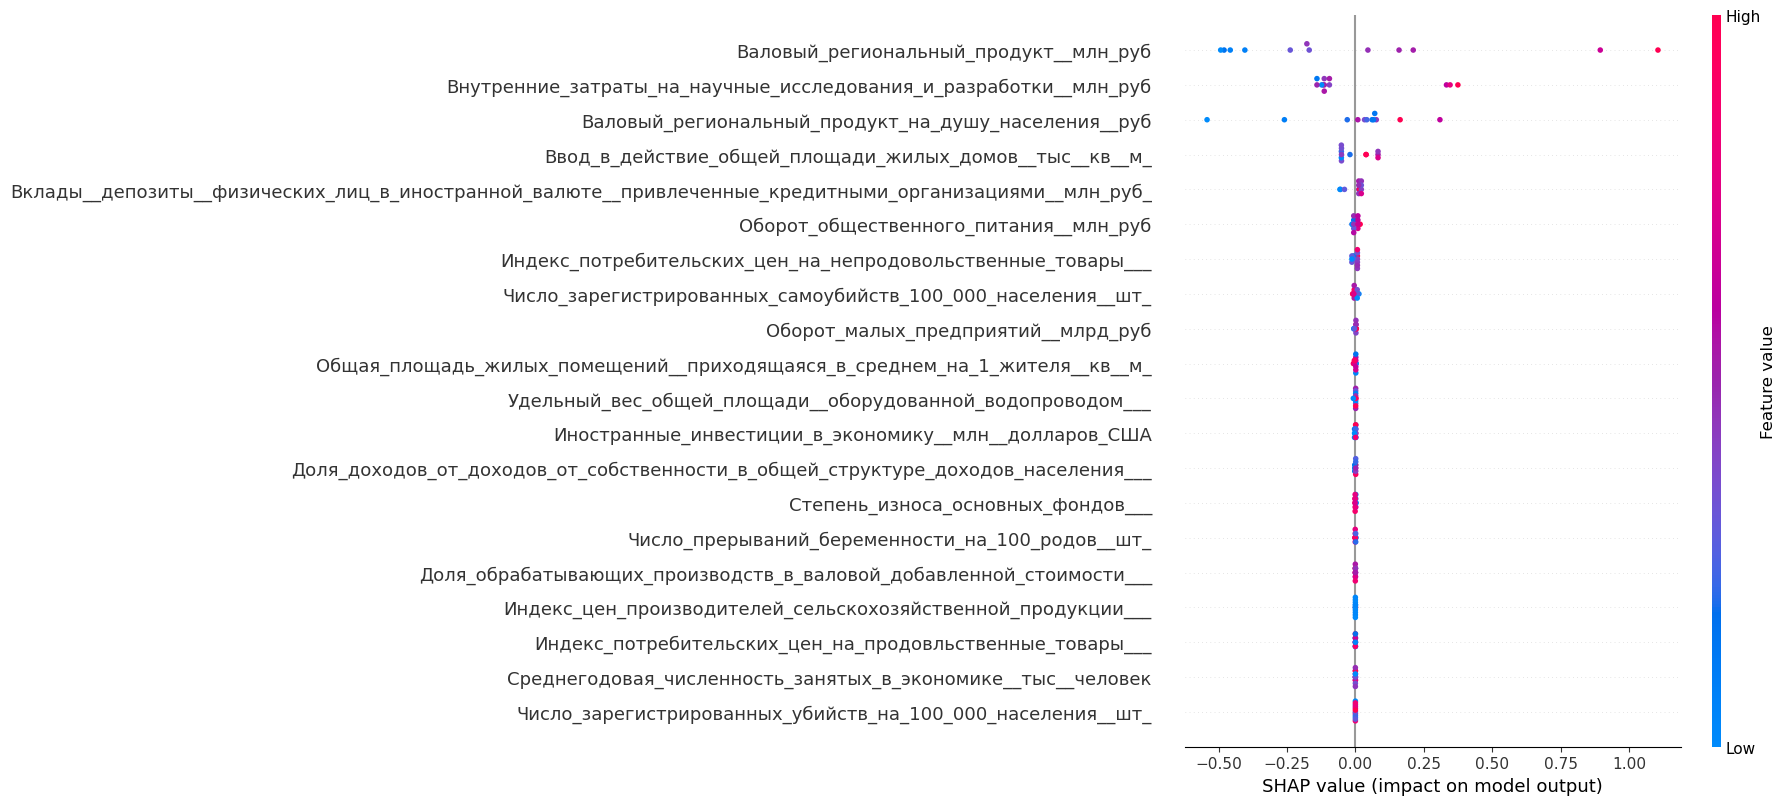

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


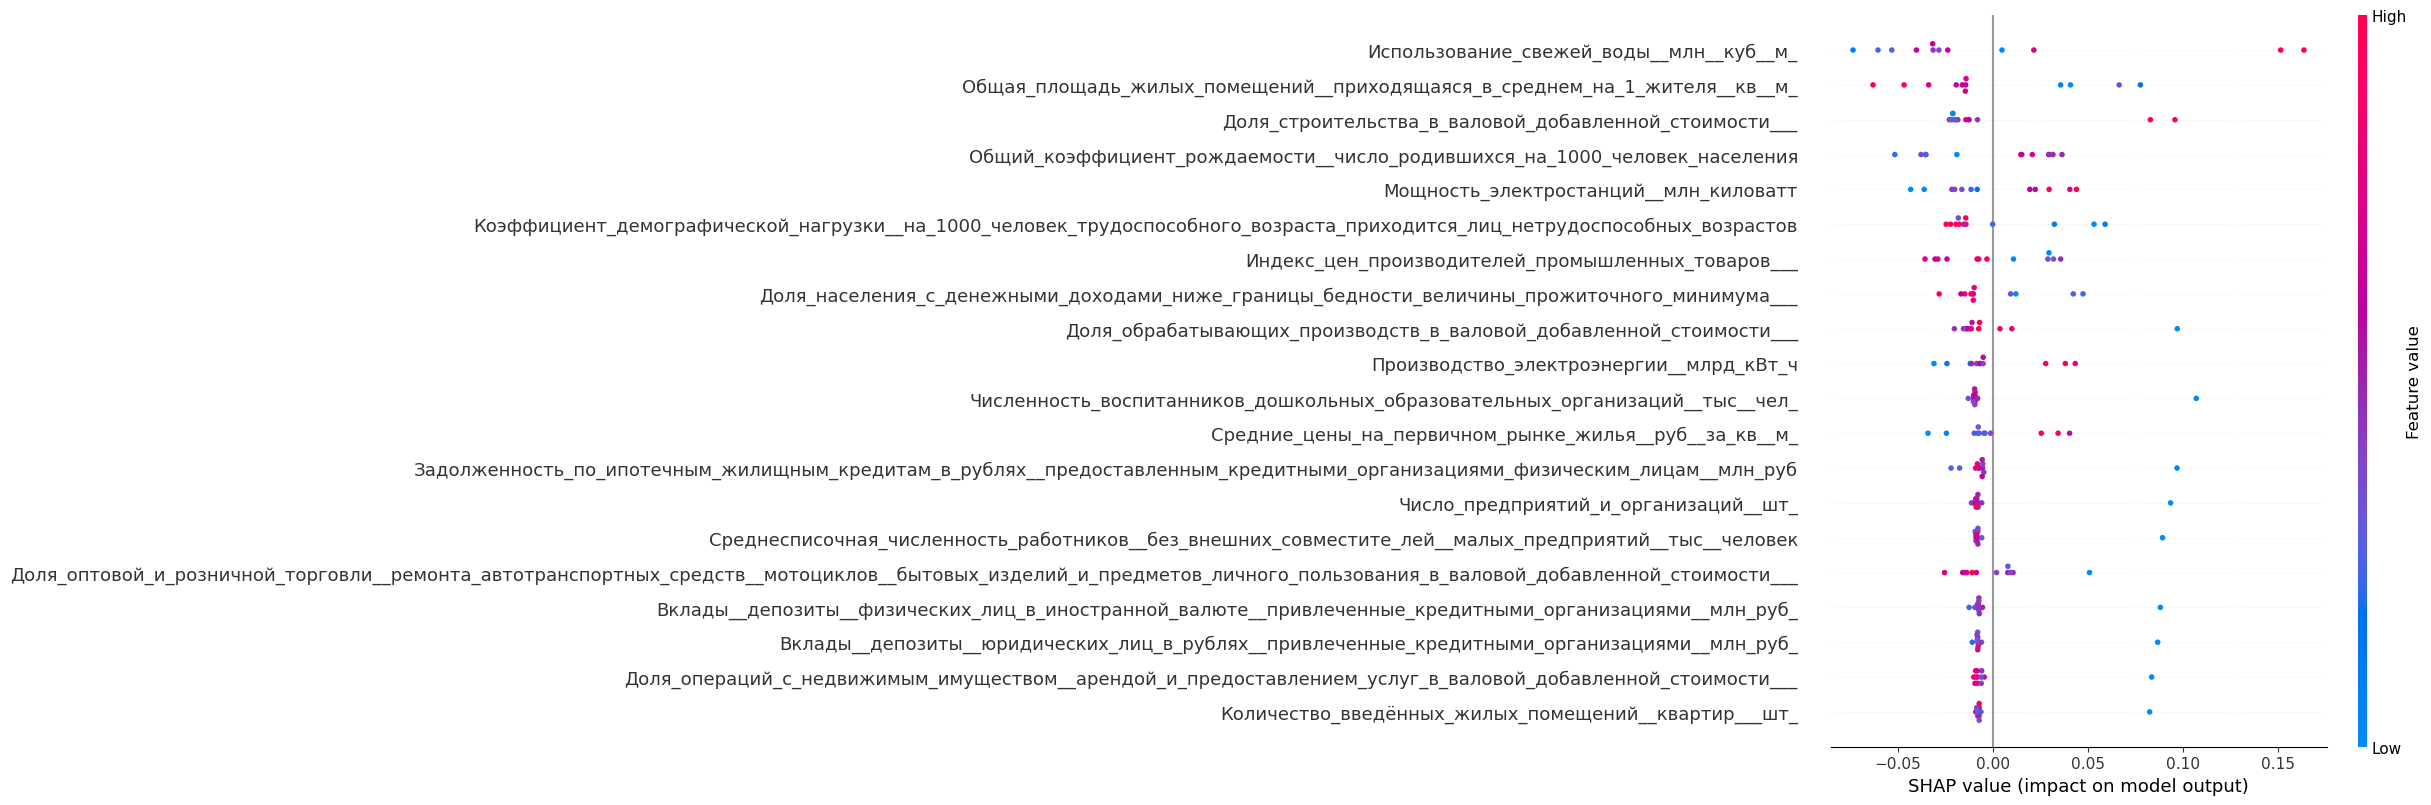

C:\Users\nikid\SHAP-значимость факторов 2022 г.xlsx

In [4]:
# Обучение модели для SHAP-анализа для target_1
model_sh_1 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
model_sh_1.fit(X_1, Y_1)
explainer_1 = shap.Explainer(model_sh_1, X_1)
shap_values_1 = explainer_1(X_1)
shap.summary_plot(shap_values_1, X_1)

# Обучение модели для SHAP-анализа для target_2
model_sh_2 = ExtraTreesRegressor(n_estimators=200, max_depth=4, random_state=42)
model_sh_2.fit(X_2, Y_2)
explainer_2 = shap.Explainer(model_sh_2, X_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2, X_2)

# Расчёт средней важности факторов на основе SHAP-анализа с сохранением знака влияния
importance_1 = pd.DataFrame({
    "Фактор": X_1.columns,
    "Важность": shap_values_1.values.mean(axis=0)
})
importance_2 = pd.DataFrame({
    "Фактор": X_2.columns,
    "Важность": shap_values_2.values.mean(axis=0)
})
grouped_importance_1 = importance_1.groupby("Фактор", as_index=False)["Важность"].mean()
grouped_importance_2 = importance_2.groupby("Фактор", as_index=False)["Важность"].mean()
filtered_importance_1 = grouped_importance_1[grouped_importance_1["Важность"] != 0].sort_values(by="Важность", ascending=False)
filtered_importance_2 = grouped_importance_2[grouped_importance_2["Важность"] != 0].sort_values(by="Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
with pd.ExcelWriter("SHAP-значимость факторов 2022 г.xlsx") as writer:
    filtered_importance_1.to_excel(writer, sheet_name="SHAP_для_ИвОК", index=False)
    filtered_importance_2.to_excel(writer, sheet_name="SHAP_для_ИвОК_на_душу", index=False)
FileLink("SHAP-значимость факторов 2022 г.xlsx")

## Подготовка к расчёту композитных индексов для 2022 г. (расчёт произведения значимости и значения каждого показателя)

In [5]:
# Извлекается список значимых факторов по SHAP-анализу
selected_features_1 = filtered_importance_1["Фактор"].tolist()
selected_features_2 = filtered_importance_2["Фактор"].tolist()

# Формирование таблицы для target_1 в длинном формате
df_comp1 = X_1.reset_index() 
df_comp1 = df_comp1[["Регион"] + selected_features_1]
df_comp1_long = pd.melt(df_comp1, id_vars="Регион", var_name="Показатель", value_name="Значение_2022")

# Объединение таблицы с важностью факторов
df_comp1_long = df_comp1_long.merge(filtered_importance_1, left_on="Показатель", right_on="Фактор", how="inner")
df_comp1_long = df_comp1_long[["Регион", "Показатель", "Значение_2022", "Важность"]]

# Вычисление произведения: значение показателя * важность
df_comp1_long["Произведение"] = df_comp1_long["Значение_2022"] * df_comp1_long["Важность"]

# Формирование таблицы для target_2 в длинном формате
df_comp2 = X_2.reset_index()
df_comp2 = df_comp2[["Регион"] + selected_features_2]
df_comp2_long = pd.melt(df_comp2, id_vars="Регион", var_name="Показатель", value_name="Значение_2022")

# Объединение таблицы с важностью факторов
df_comp2_long = df_comp2_long.merge(filtered_importance_2, left_on="Показатель", right_on="Фактор", how="inner")
df_comp2_long = df_comp2_long[["Регион", "Показатель", "Значение_2022", "Важность"]]

# Вычисление произведения: значение показателя * важность
df_comp2_long["Произведение"] = df_comp2_long["Значение_2022"] * df_comp2_long["Важность"]

# Сохранение промежуточных результатов в Excel
with pd.ExcelWriter("Композитный индекс инвестиционной привлекательности для каждого показателя 2022 г.xlsx") as writer:
    df_comp1_long.to_excel(writer, sheet_name="ИвОК_2022", index=False)
    df_comp2_long.to_excel(writer, sheet_name="ИвОК_на_душу_2022", index=False)
FileLink("Композитный индекс инвестиционной привлекательности для каждого показателя 2022 г.xlsx")

C:\Users\nikid\Композитный индекс инвестиционной привлекательности для каждого показателя 2022 г.xlsx

## Расчёт композитных индексов для 2022 г.

In [6]:
# Для target_1
composite_index_1 = df_comp1_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_1 = composite_index_1.rename(columns={"Произведение": "Композитный_индекс_ИвОК"})
composite_index_1 = composite_index_1.sort_values(by="Композитный_индекс_ИвОК", ascending=False)

# Для target_2
composite_index_2 = df_comp2_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_2 = composite_index_2.rename(columns={"Произведение": "Композитный_индекс_ИвОК_на_душу"})
composite_index_2 = composite_index_2.sort_values(by="Композитный_индекс_ИвОК_на_душу", ascending=False)

# Сохранение сводных таблиц в один Excel-файл
with pd.ExcelWriter("Композитный индекс по регионам 2022 г.xlsx") as writer:
    composite_index_1.to_excel(writer, sheet_name="ИвОК_Композитный индекс", index=False)
    composite_index_2.to_excel(writer, sheet_name="ИвОК на душу_Композитный индекс", index=False)
FileLink("Композитный индекс по регионам 2022 г.xlsx")

C:\Users\nikid\Композитный индекс по регионам 2022 г.xlsx

# Прогнозирование данных и оценка на их основе инвестиционной привлекательности регионов

## Оценка корректности прогнозирования с помощью библиотеки "Prophet"

In [7]:
# Формирование датасета в длинном формате
df_long = df_l.melt(id_vars=["Регион", "Показатель"], 
                    var_name="Год", 
                    value_name="Значение")

# Создаётся копия датасета
all_df = df_long.copy()

# Оценка ошибок прогнозирования с Prophet для всех временных рядов
error_results = []
grouped = all_df.groupby(["Регион", "Показатель"])

for (region, indicator), group in grouped:
    # Сортировка по году
    group = group.sort_values("Год")
    n = len(group)
    train_size = int(n * 0.8)
    
    # Разбиение на обучающую и тестовую выборки
    train_data = group.iloc[:train_size].copy()
    test_data = group.iloc[train_size:].copy()
    
    # Приведение столбца "Год" к целочисленному типу для тестовой выборки
    test_data["Год"] = test_data["Год"].astype(int)
    
    # Подготовка данных для Prophet: переименование столбца и преобразование года в дату
    train_data["ds"] = pd.to_datetime(train_data["Год"].astype(str) + "-12-31")
    train_data.rename(columns={"Значение": "y"}, inplace=True)
    
    # Обучение модели Prophet на обучающей выборке
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    model.fit(train_data[["ds", "y"]])
    
    # Прогнозирование на число периодов, равное длине тестовой выборки
    periods = len(test_data)
    future = model.make_future_dataframe(periods=periods, freq='YS')
    forecast = model.predict(future)
    
    # Отбор прогнозов для тестового периода 
    forecast_test = forecast[forecast["ds"] > train_data["ds"].max()].copy()
    forecast_test["Год"] = forecast_test["ds"].dt.year.astype(int)
    
    # Объединение прогнозов с тестовыми данными по столбцу "Год"
    merged = pd.merge(test_data, forecast_test[["Год", "yhat"]], on="Год", how="left")
    
    # Вычисление метрик ошибок: RMSE, MAE и SMAPE
    y_true = merged["Значение"]
    y_pred = merged["yhat"]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)
    
    error_results.append({
        "Регион": region,
        "Показатель": indicator,
        "RMSE": rmse,
        "MAE": mae,
        "SMAPE": smape
    })

# Вычисление общих средних метрик по всем временным рядам
overall_rmse = np.mean([res["RMSE"] for res in error_results])
overall_mae = np.mean([res["MAE"] for res in error_results])
overall_smape = np.mean([res["SMAPE"] for res in error_results])

print("Общие средние метрики прогнозирования с Prophet:")
print(f"  RMSE: {overall_rmse:.2f}")
print(f"  MAE: {overall_mae:.2f}")
print(f"  SMAPE: {overall_smape:.2f}%")

14:37:39 - cmdstanpy - INFO - Chain [1] start processing
14:37:44 - cmdstanpy - INFO - Chain [1] done processing
14:37:44 - cmdstanpy - INFO - Chain [1] start processing
14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:53 - cmdstanpy - INFO - Chain [1] start processing
14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:53 - cmdstanpy - INFO - Chain [1] start processing
14:37:53 - cmdstanpy - INFO - Chain [1] done processing
14:37:53 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:37:54 - cmdstanpy - INFO - Chain [1] done processing
14:37:54 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing
14:38:02 - cmdstanpy - INFO - Chain [1]

Общие средние метрики прогнозирования с Prophet:
  RMSE: 0.42
  MAE: 0.37
  SMAPE: 8.43%


## Прогнозирование данных на 2023 - 2027 годы

In [8]:
# Создаётся список для прогнозов
forecast_list = []

for (region, indicator), group in grouped:
    # Прогнозируется временной ряд с помощью функции forecast_series (прогноз на 5 лет)
    fc = forecast_series(group, periods=5)
    # Добавляется информацию о регионе и показателе
    fc["Регион"] = region
    fc["Показатель"] = indicator
    forecast_list.append(fc)

# Прогнозы объединяются в один DataFrame
df_forecast = pd.concat(forecast_list, ignore_index=True)

# Столбец "Прогноз" переименовывается в "Значение" для единого формата
df_forecast.rename(columns={"Прогноз": "Значение"}, inplace=True)

# Датасет с прогнозами переводится в широкий формат, чтобы была такая же структура, как в df_l:
df_forecast_pivot = df_forecast.pivot_table(index=["Регион", "Показатель"],
                                            columns="Год",
                                            values="Значение").reset_index()

# Определяется порядок столбцов: сначала "Регион" и "Показатель", затем годы по порядку
forecast_years = [2023, 2024, 2025, 2026, 2027]
df_forecast_pivot = df_forecast_pivot[["Регион", "Показатель"] + forecast_years]

# Сохранение результата в Excel
df_forecast_pivot.to_excel("Прогноз переменных 2023-2027.xlsx", index=False)
FileLink("Прогноз переменных 2023-2027.xlsx")

16:07:33 - cmdstanpy - INFO - Chain [1] start processing
16:07:43 - cmdstanpy - INFO - Chain [1] done processing
16:07:44 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:54 - cmdstanpy - INFO - Chain [1] done processing
16:07:54 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1] done processing
16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1] done processing
16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1] done processing
16:07:55 - cmdstanpy - INFO - Chain [1] start processing
16:07:55 - cmdstanpy - INFO - Chain [1] done processing
16:07:56 - cmdstanpy - INFO - Chain [1] start processing
16:07:56 - cmdstanpy - INFO - Chain [1]

C:\Users\nikid\Прогноз переменных 2023-2027.xlsx

## Выбор модели МО перед SHAP-анализом для 2023г.

In [9]:
# Фиксируется 2023 год для анализа
year_column = 2023

# Подготовка сводных таблиц для каждого целевого показателя
df_pivot_1 = prepare_data(df_forecast_pivot, target_to_exclude=target_2, year_column=year_column)
df_pivot_2 = prepare_data(df_forecast_pivot, target_to_exclude=target_1, year_column=year_column)

# Формируются признаки (X) и целевые переменные (Y)
X_1 = clean_column_names(df_pivot_1.drop(columns=[target_1]))
Y_1 = df_pivot_1[target_1]
X_2 = clean_column_names(df_pivot_2.drop(columns=[target_2]))
Y_2 = df_pivot_2[target_2]

# Разбиение данных для target_1
print("Оценка качества для целевой переменной №1 - ИвОК")
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_1
model_xgb1 = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
rmse_xgb1, mae_xgb1, smape_xgb1 = evaluate_model(model_xgb1, X1_train, X1_test, Y1_train, Y1_test)

model_lgb1 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb1, mae_lgb1, smape_lgb1 = evaluate_model(model_lgb1, X1_train, X1_test, Y1_train, Y1_test)

model_et1 = ExtraTreesRegressor(n_estimators=100, max_depth=3, random_state=42)
rmse_et1, mae_et1, smape_et1 = evaluate_model(model_et1, X1_train, X1_test, Y1_train, Y1_test)

print(f"Target 1 ({target_1}):")
print(f"  XGBoost    - RMSE: {rmse_xgb1:.2f}, MAE: {mae_xgb1:.2f}, SMAPE: {smape_xgb1:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb1:.2f}, MAE: {mae_lgb1:.2f}, SMAPE: {smape_lgb1:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et1:.2f}, MAE: {mae_et1:.2f}, SMAPE: {smape_et1:.2f}%")

# Разбиение данных для target_2
print("Оценка качества для целевой переменной №2 - ИвОК на д.н.")
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_2
model_xgb2 = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
rmse_xgb2, mae_xgb2, smape_xgb2 = evaluate_model(model_xgb2, X2_train, X2_test, Y2_train, Y2_test)

model_lgb2 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb2, mae_lgb2, smape_lgb2 = evaluate_model(model_lgb2, X2_train, X2_test, Y2_train, Y2_test)

model_et2 = ExtraTreesRegressor(n_estimators=250, max_depth=3, random_state=42)
rmse_et2, mae_et2, smape_et2 = evaluate_model(model_et2, X2_train, X2_test, Y2_train, Y2_test)

print(f"Target 2 ({target_2}):")
print(f"  XGBoost    - RMSE: {rmse_xgb2:.2f}, MAE: {mae_xgb2:.2f}, SMAPE: {smape_xgb2:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb2:.2f}, MAE: {mae_lgb2:.2f}, SMAPE: {smape_lgb2:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et2:.2f}, MAE: {mae_et2:.2f}, SMAPE: {smape_et2:.2f}%")

Оценка качества для целевой переменной №1 - ИвОК
Target 1 (Инвестиции в основной капитал, млн руб):
  XGBoost    - RMSE: 0.78, MAE: 0.51, SMAPE: 4.25%
  LightGBM   - RMSE: 0.80, MAE: 0.77, SMAPE: 6.48%
  ExtraTrees - RMSE: 0.60, MAE: 0.57, SMAPE: 4.80%
Оценка качества для целевой переменной №2 - ИвОК на д.н.
Target 2 (Инвестиции в основной капитал на душу населения, руб):
  XGBoost    - RMSE: 0.67, MAE: 0.60, SMAPE: 4.88%
  LightGBM   - RMSE: 0.82, MAE: 0.75, SMAPE: 6.27%
  ExtraTrees - RMSE: 0.98, MAE: 0.84, SMAPE: 6.96%


## SHAP-анализ для 2023 г.

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


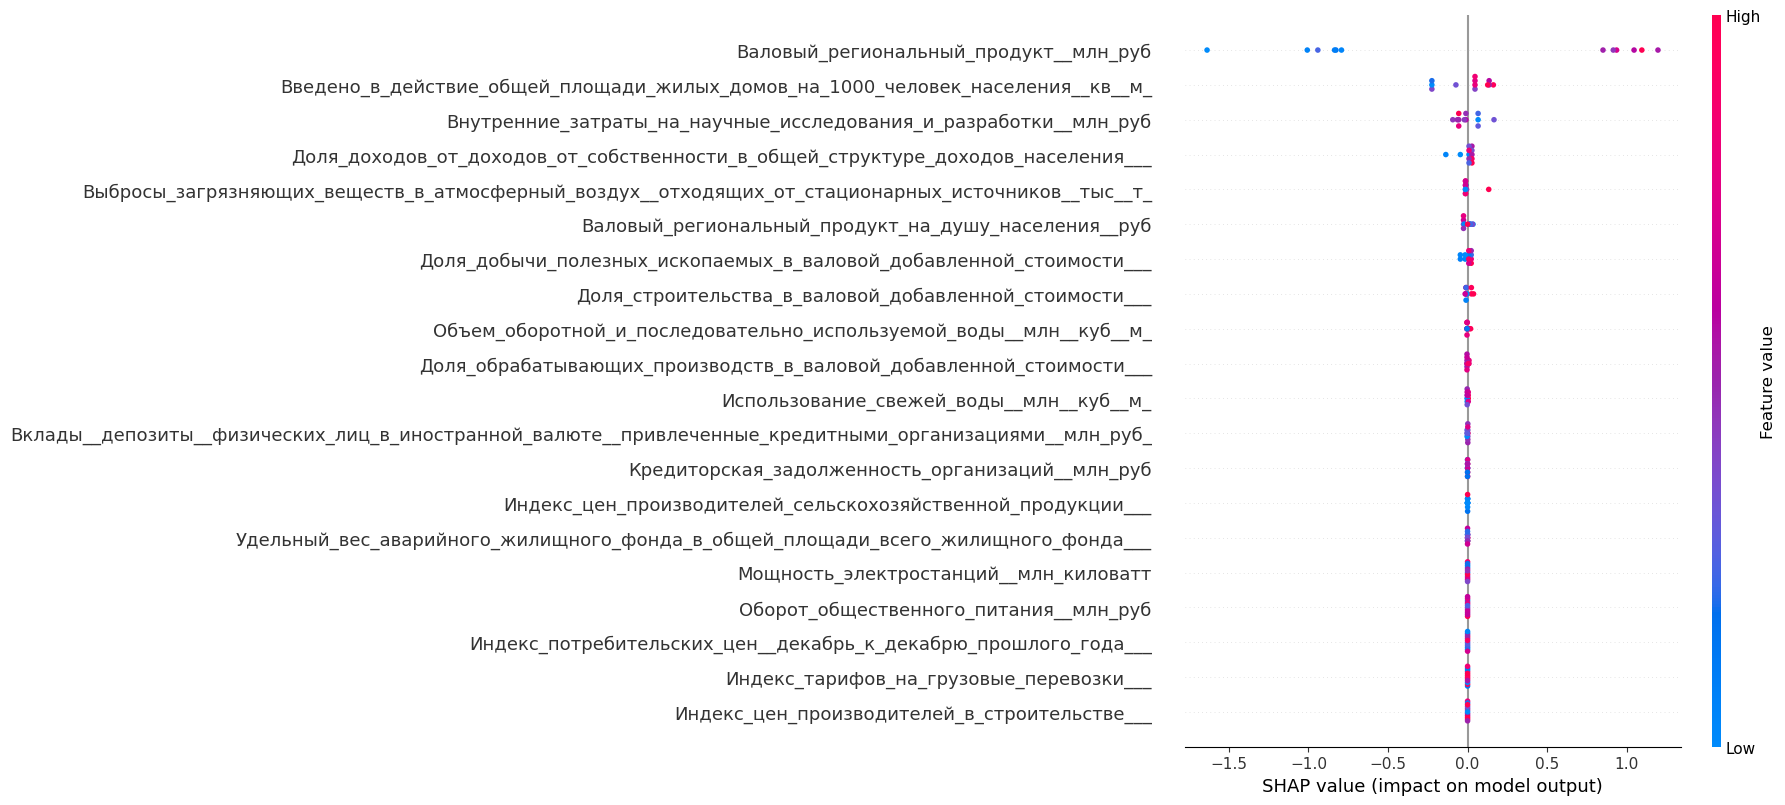

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


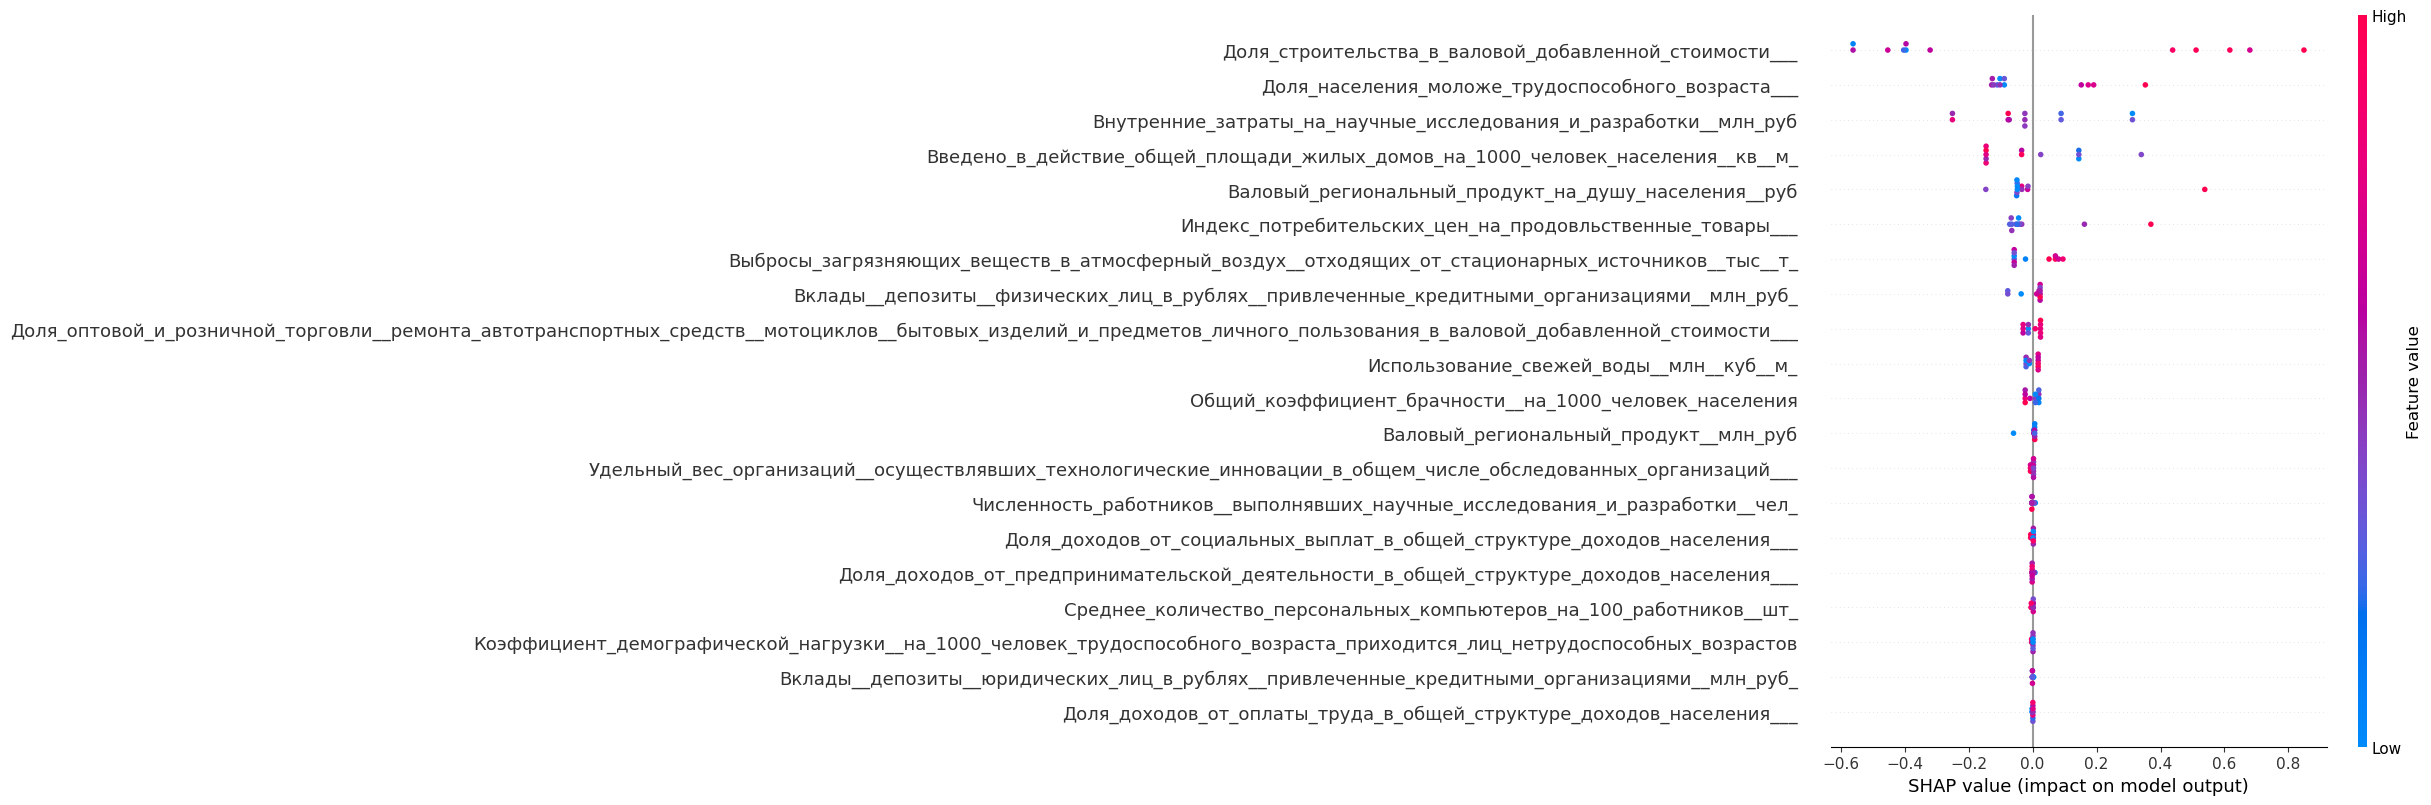

C:\Users\nikid\SHAP-значимость факторов 2023 г.xlsx

In [10]:
# Обучение модели для SHAP-анализа для target_1
model_sh_1 = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model_sh_1.fit(X_1, Y_1)
explainer_1 = shap.Explainer(model_sh_1, X_1)
shap_values_1 = explainer_1(X_1)
shap.summary_plot(shap_values_1, X_1)

# Обучение модели для SHAP-анализа для target_2
model_sh_2 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
model_sh_2.fit(X_2, Y_2)
explainer_2 = shap.Explainer(model_sh_2, X_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2, X_2)

# Расчёт средней важности факторов на основе SHAP-анализа
importance_1 = pd.DataFrame({
    "Фактор": X_1.columns,
    "Важность": shap_values_1.values.mean(axis=0)
})
importance_2 = pd.DataFrame({
    "Фактор": X_2.columns,
    "Важность": shap_values_2.values.mean(axis=0)
})
grouped_importance_1 = importance_1.groupby("Фактор", as_index=False)["Важность"].mean()
grouped_importance_2 = importance_2.groupby("Фактор", as_index=False)["Важность"].mean()
filtered_importance_1 = grouped_importance_1[grouped_importance_1["Важность"] != 0].sort_values(by="Важность", ascending=False)
filtered_importance_2 = grouped_importance_2[grouped_importance_2["Важность"] != 0].sort_values(by="Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
with pd.ExcelWriter("SHAP-значимость факторов 2023 г.xlsx") as writer:
    filtered_importance_1.to_excel(writer, sheet_name="SHAP_для_ИвОК", index=False)
    filtered_importance_2.to_excel(writer, sheet_name="SHAP_для_ИвОК_на_душу", index=False)
FileLink("SHAP-значимость факторов 2023 г.xlsx")

## Расчёт композитных индексов для 2023 г.

In [11]:
# Извлекается список значимых факторов по SHAP-анализу
selected_features_1 = filtered_importance_1["Фактор"].tolist()
selected_features_2 = filtered_importance_2["Фактор"].tolist()

# Формирование таблицы для target_1 в длинном формате
df_comp1 = X_1.reset_index() 
df_comp1 = df_comp1[["Регион"] + selected_features_1]
df_comp1_long = pd.melt(df_comp1, id_vars="Регион", var_name="Показатель", value_name="Значение_2023")

# Объединение таблицы с важностью факторов
df_comp1_long = df_comp1_long.merge(filtered_importance_1, left_on="Показатель", right_on="Фактор", how="inner")
df_comp1_long = df_comp1_long[["Регион", "Показатель", "Значение_2023", "Важность"]]

# Вычисление произведения: значение показателя * важность
df_comp1_long["Произведение"] = df_comp1_long["Значение_2023"] * df_comp1_long["Важность"]

# Формирование таблицы для target_2 в длинном формате
df_comp2 = X_2.reset_index()
df_comp2 = df_comp2[["Регион"] + selected_features_2]
df_comp2_long = pd.melt(df_comp2, id_vars="Регион", var_name="Показатель", value_name="Значение_2023")

# Объединение таблицы с важностью факторов
df_comp2_long = df_comp2_long.merge(filtered_importance_2, left_on="Показатель", right_on="Фактор", how="inner")

# Вычисление произведения: значение показателя * важность
df_comp2_long["Произведение"] = df_comp2_long["Значение_2023"] * df_comp2_long["Важность"]

# Для target_1
composite_index_1 = df_comp1_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_1 = composite_index_1.rename(columns={"Произведение": "Композитный_индекс_ИвОК"})
composite_index_1 = composite_index_1.sort_values(by="Композитный_индекс_ИвОК", ascending=False)

# Для target_2
composite_index_2 = df_comp2_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_2 = composite_index_2.rename(columns={"Произведение": "Композитный_индекс_ИвОК_на_душу"})
composite_index_2 = composite_index_2.sort_values(by="Композитный_индекс_ИвОК_на_душу", ascending=False)

# Сохранение сводных таблиц в один Excel-файл
with pd.ExcelWriter("Композитный индекс по регионам 2023 г.xlsx") as writer:
    composite_index_1.to_excel(writer, sheet_name="ИвОК_Композитный индекс", index=False)
    composite_index_2.to_excel(writer, sheet_name="ИвОК на душу_Композитный индекс", index=False)
FileLink("Композитный индекс по регионам 2023 г.xlsx")

C:\Users\nikid\Композитный индекс по регионам 2023 г.xlsx

## Выбор модели МО перед SHAP-анализом для 2024 г.

In [12]:
# Фиксируется 2024 год для анализа
year_column = 2024 

df_pivot_1 = prepare_data(df_forecast_pivot, target_to_exclude=target_2, year_column=year_column)
df_pivot_2 = prepare_data(df_forecast_pivot, target_to_exclude=target_1, year_column=year_column)

# Формируются признаки (X) и целевые переменные (Y)
X_1 = clean_column_names(df_pivot_1.drop(columns=[target_1]))
Y_1 = df_pivot_1[target_1]
X_2 = clean_column_names(df_pivot_2.drop(columns=[target_2]))
Y_2 = df_pivot_2[target_2]

# Разбиение данных для target_1
print("Оценка качества для целевой переменной №1 - ИвОК")
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_1
model_xgb1 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
rmse_xgb1, mae_xgb1, smape_xgb1 = evaluate_model(model_xgb1, X1_train, X1_test, Y1_train, Y1_test)

model_lgb1 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb1, mae_lgb1, smape_lgb1 = evaluate_model(model_lgb1, X1_train, X1_test, Y1_train, Y1_test)

model_et1 = ExtraTreesRegressor(n_estimators=100, max_depth=3, random_state=42)
rmse_et1, mae_et1, smape_et1 = evaluate_model(model_et1, X1_train, X1_test, Y1_train, Y1_test)

print(f"Target 1 ({target_1}):")
print(f"  XGBoost    - RMSE: {rmse_xgb1:.2f}, MAE: {mae_xgb1:.2f}, SMAPE: {smape_xgb1:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb1:.2f}, MAE: {mae_lgb1:.2f}, SMAPE: {smape_lgb1:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et1:.2f}, MAE: {mae_et1:.2f}, SMAPE: {smape_et1:.2f}%")

# Разбиение данных для target_2
print("Оценка качества для целевой переменной №2 - ИвОК на д.н.")
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_2
model_xgb2 = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
rmse_xgb2, mae_xgb2, smape_xgb2 = evaluate_model(model_xgb2, X2_train, X2_test, Y2_train, Y2_test)

model_lgb2 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb2, mae_lgb2, smape_lgb2 = evaluate_model(model_lgb2, X2_train, X2_test, Y2_train, Y2_test)

model_et2 = ExtraTreesRegressor(n_estimators=200, max_depth=5, random_state=42)
rmse_et2, mae_et2, smape_et2 = evaluate_model(model_et2, X2_train, X2_test, Y2_train, Y2_test)

print(f"Target 2 ({target_2}):")
print(f"  XGBoost    - RMSE: {rmse_xgb2:.2f}, MAE: {mae_xgb2:.2f}, SMAPE: {smape_xgb2:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb2:.2f}, MAE: {mae_lgb2:.2f}, SMAPE: {smape_lgb2:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et2:.2f}, MAE: {mae_et2:.2f}, SMAPE: {smape_et2:.2f}%")

Оценка качества для целевой переменной №1 - ИвОК
Target 1 (Инвестиции в основной капитал, млн руб):
  XGBoost    - RMSE: 0.63, MAE: 0.62, SMAPE: 5.45%
  LightGBM   - RMSE: 0.51, MAE: 0.43, SMAPE: 3.60%
  ExtraTrees - RMSE: 0.39, MAE: 0.30, SMAPE: 2.57%
Оценка качества для целевой переменной №2 - ИвОК на д.н.
Target 2 (Инвестиции в основной капитал на душу населения, руб):
  XGBoost    - RMSE: 0.65, MAE: 0.51, SMAPE: 4.11%
  LightGBM   - RMSE: 0.48, MAE: 0.41, SMAPE: 3.36%
  ExtraTrees - RMSE: 0.54, MAE: 0.53, SMAPE: 4.32%


## Проведение SHAP-анализа для 2024 г.

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


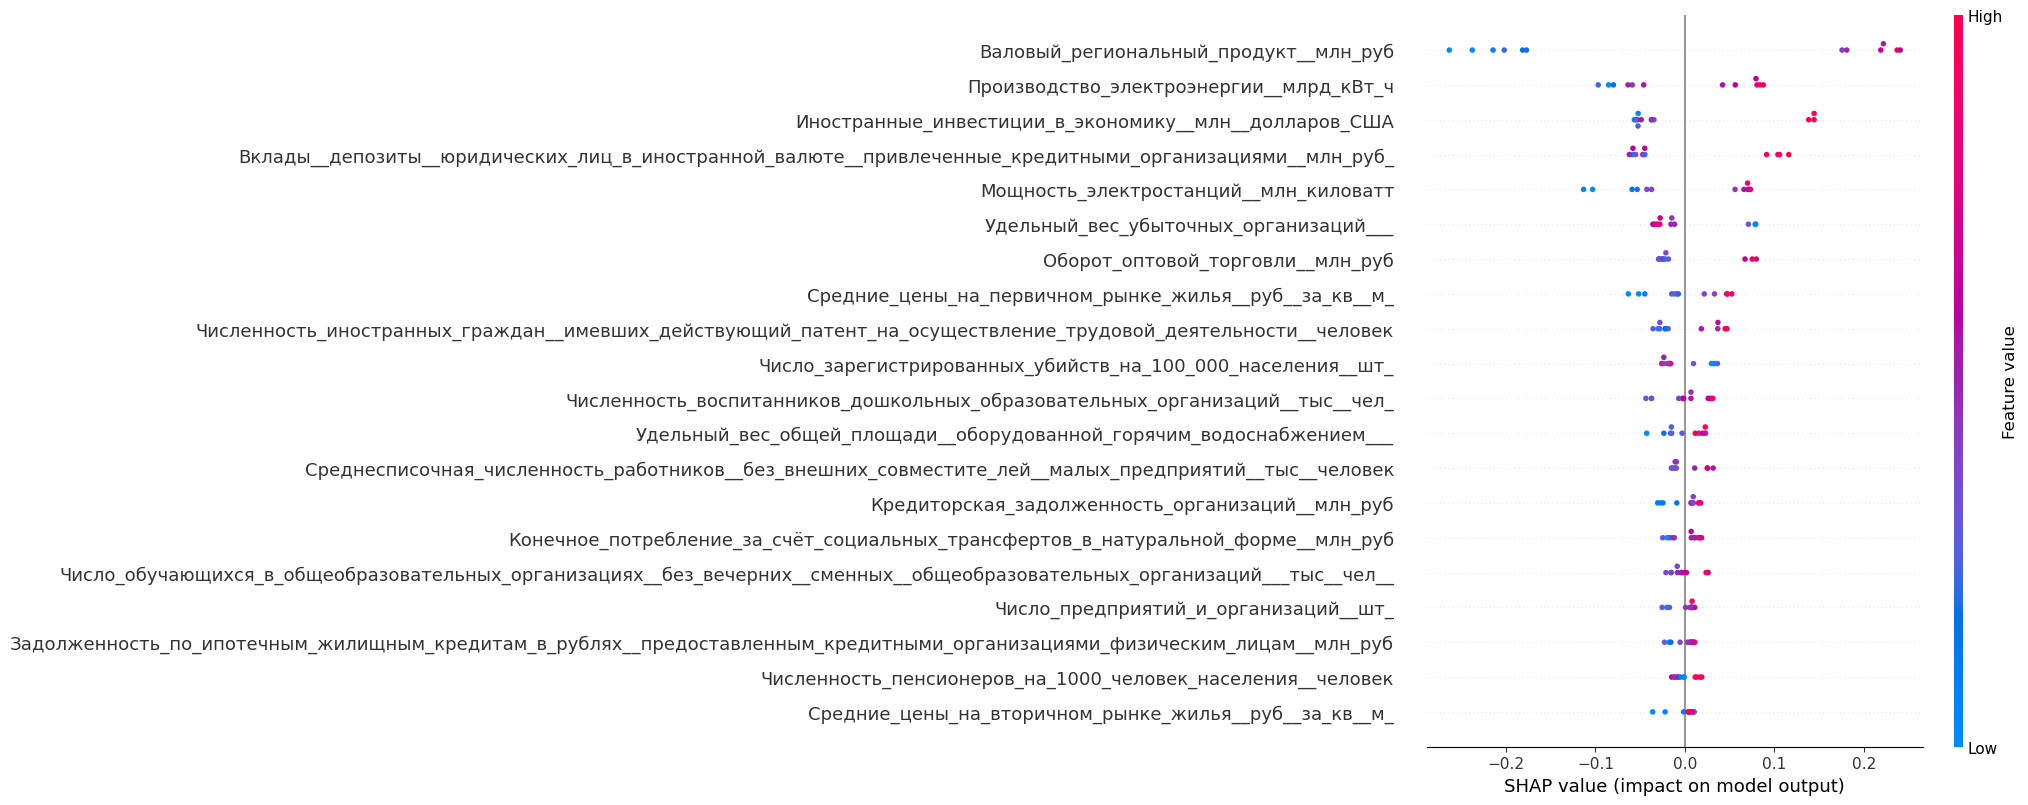

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


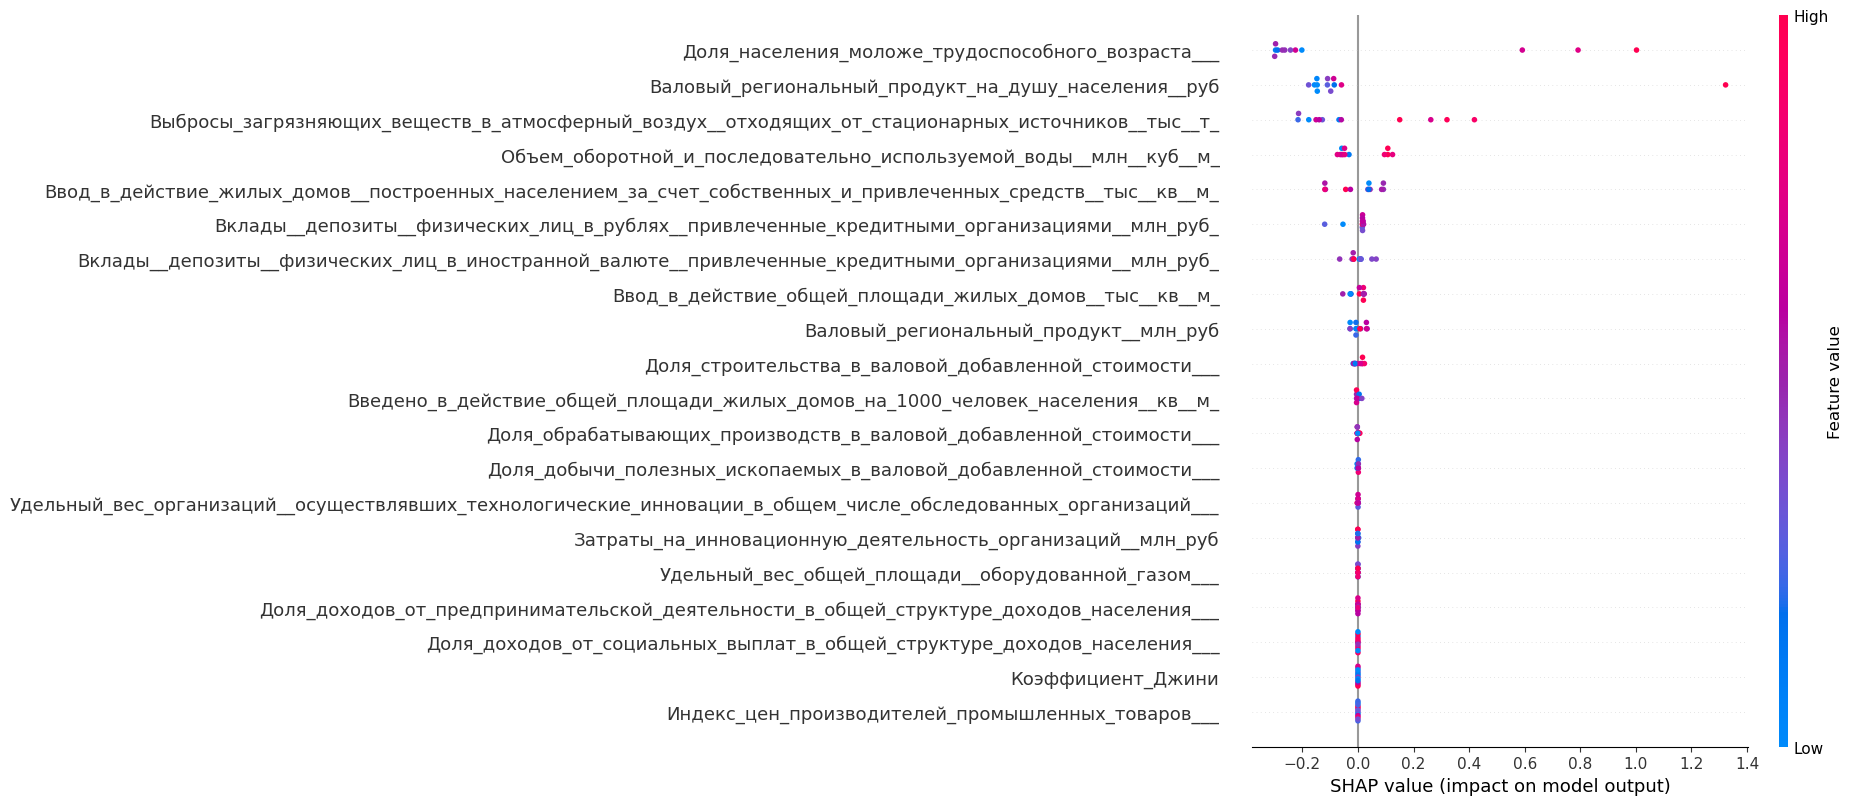

C:\Users\nikid\SHAP-значимость факторов 2024 г.xlsx

In [13]:
# Обучение модели для SHAP-анализа для target_1
model_sh_1 = ExtraTreesRegressor(n_estimators=100, max_depth=3, random_state=42)
model_sh_1.fit(X_1, Y_1)
explainer_1 = shap.Explainer(model_sh_1, X_1)
shap_values_1 = explainer_1(X_1)
shap.summary_plot(shap_values_1, X_1)

# Обучение модели для SHAP-анализа для target_2
model_sh_2 = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
model_sh_2.fit(X_2, Y_2)
explainer_2 = shap.Explainer(model_sh_2, X_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2, X_2)

# Расчёт средней важности факторов на основе SHAP-анализа с сохранением знака влияния
importance_1 = pd.DataFrame({
    "Фактор": X_1.columns,
    "Важность": shap_values_1.values.mean(axis=0)
})
importance_2 = pd.DataFrame({
    "Фактор": X_2.columns,
    "Важность": shap_values_2.values.mean(axis=0)
})
grouped_importance_1 = importance_1.groupby("Фактор", as_index=False)["Важность"].mean()
grouped_importance_2 = importance_2.groupby("Фактор", as_index=False)["Важность"].mean()
filtered_importance_1 = grouped_importance_1[grouped_importance_1["Важность"] != 0].sort_values(by="Важность", ascending=False)
filtered_importance_2 = grouped_importance_2[grouped_importance_2["Важность"] != 0].sort_values(by="Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
with pd.ExcelWriter("SHAP-значимость факторов 2024 г.xlsx") as writer:
    filtered_importance_1.to_excel(writer, sheet_name="SHAP_для_ИвОК", index=False)
    filtered_importance_2.to_excel(writer, sheet_name="SHAP_для_ИвОК_на_душу", index=False)
FileLink("SHAP-значимость факторов 2024 г.xlsx")

## Расчёт композитных индексов для 2024 г.

In [14]:
# Извлекается список значимых факторов по SHAP-анализу
selected_features_1 = filtered_importance_1["Фактор"].tolist()
selected_features_2 = filtered_importance_2["Фактор"].tolist()

# Формирование таблицы для target_1 в длинном формате
df_comp1 = X_1.reset_index() 
df_comp1 = df_comp1[["Регион"] + selected_features_1]
df_comp1_long = pd.melt(df_comp1, id_vars="Регион", var_name="Показатель", value_name="Значение_2024")

# Объединение таблицы с важностью факторов
df_comp1_long = df_comp1_long.merge(filtered_importance_1, left_on="Показатель", right_on="Фактор", how="inner")
df_comp1_long = df_comp1_long[["Регион", "Показатель", "Значение_2024", "Важность"]]

# Вычисление произведения: значение показателя * важность
df_comp1_long["Произведение"] = df_comp1_long["Значение_2024"] * df_comp1_long["Важность"]

# Формирование таблицы для target_2 в длинном формате
df_comp2 = X_2.reset_index()
df_comp2 = df_comp2[["Регион"] + selected_features_2]
df_comp2_long = pd.melt(df_comp2, id_vars="Регион", var_name="Показатель", value_name="Значение_2024")

# Объединение таблицы с важностью факторов
df_comp2_long = df_comp2_long.merge(filtered_importance_2, left_on="Показатель", right_on="Фактор", how="inner")
df_comp2_long = df_comp2_long[["Регион", "Показатель", "Значение_2024", "Важность"]]

# Вычисление произведения: значение показателя * важность
df_comp2_long["Произведение"] = df_comp2_long["Значение_2024"] * df_comp2_long["Важность"]

# Для target_1
composite_index_1 = df_comp1_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_1 = composite_index_1.rename(columns={"Произведение": "Композитный_индекс_ИвОК"})
composite_index_1 = composite_index_1.sort_values(by="Композитный_индекс_ИвОК", ascending=False)

# Для target_2
composite_index_2 = df_comp2_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_2 = composite_index_2.rename(columns={"Произведение": "Композитный_индекс_ИвОК_на_душу"})
composite_index_2 = composite_index_2.sort_values(by="Композитный_индекс_ИвОК_на_душу", ascending=False)

# Сохранение сводных таблиц в один Excel-файл
with pd.ExcelWriter("Композитный индекс по регионам 2024 г.xlsx") as writer:
    composite_index_1.to_excel(writer, sheet_name="ИвОК_Композитный индекс", index=False)
    composite_index_2.to_excel(writer, sheet_name="ИвОК на душу_Композитный индекс", index=False)
FileLink("Композитный индекс по регионам 2024 г.xlsx")

C:\Users\nikid\Композитный индекс по регионам 2024 г.xlsx

## Выбор модели МО перед SHAP-анализом для 2025 г.

In [15]:
# Определяются целевые переменные и фиксируется 2025 год для анализа
year_column = 2025


# Подготовка сводных таблиц для каждого целевого показателя
df_pivot_1 = prepare_data(df_forecast_pivot, target_to_exclude=target_2, year_column=year_column)
df_pivot_2 = prepare_data(df_forecast_pivot, target_to_exclude=target_1, year_column=year_column)

# Формируются признаки (X) и целевые переменные (Y)
X_1 = clean_column_names(df_pivot_1.drop(columns=[target_1]))
Y_1 = df_pivot_1[target_1]
X_2 = clean_column_names(df_pivot_2.drop(columns=[target_2]))
Y_2 = df_pivot_2[target_2]

# Разбиение данных для target_1
print("Оценка качества для целевой переменной №1 - ИвОК")
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_1
model_xgb1 = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
rmse_xgb1, mae_xgb1, smape_xgb1 = evaluate_model(model_xgb1, X1_train, X1_test, Y1_train, Y1_test)

model_lgb1 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb1, mae_lgb1, smape_lgb1 = evaluate_model(model_lgb1, X1_train, X1_test, Y1_train, Y1_test)

model_et1 = ExtraTreesRegressor(n_estimators=200, max_depth=2, random_state=42)
rmse_et1, mae_et1, smape_et1 = evaluate_model(model_et1, X1_train, X1_test, Y1_train, Y1_test)

print(f"Target 1 ({target_1}):")
print(f"  XGBoost    - RMSE: {rmse_xgb1:.2f}, MAE: {mae_xgb1:.2f}, SMAPE: {smape_xgb1:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb1:.2f}, MAE: {mae_lgb1:.2f}, SMAPE: {smape_lgb1:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et1:.2f}, MAE: {mae_et1:.2f}, SMAPE: {smape_et1:.2f}%")

# Разбиение данных для target_2
print("Оценка качества для целевой переменной №2 - ИвОК на д.н.")
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_2
model_xgb2 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
rmse_xgb2, mae_xgb2, smape_xgb2 = evaluate_model(model_xgb2, X2_train, X2_test, Y2_train, Y2_test)

model_lgb2 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb2, mae_lgb2, smape_lgb2 = evaluate_model(model_lgb2, X2_train, X2_test, Y2_train, Y2_test)

model_et2 = ExtraTreesRegressor(n_estimators=150, max_depth=2, random_state=42)
rmse_et2, mae_et2, smape_et2 = evaluate_model(model_et2, X2_train, X2_test, Y2_train, Y2_test)

print(f"Target 2 ({target_2}):")
print(f"  XGBoost    - RMSE: {rmse_xgb2:.2f}, MAE: {mae_xgb2:.2f}, SMAPE: {smape_xgb2:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb2:.2f}, MAE: {mae_lgb2:.2f}, SMAPE: {smape_lgb2:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et2:.2f}, MAE: {mae_et2:.2f}, SMAPE: {smape_et2:.2f}%")

Оценка качества для целевой переменной №1 - ИвОК
Target 1 (Инвестиции в основной капитал, млн руб):
  XGBoost    - RMSE: 0.60, MAE: 0.48, SMAPE: 4.41%
  LightGBM   - RMSE: 1.52, MAE: 1.48, SMAPE: 12.00%
  ExtraTrees - RMSE: 1.24, MAE: 1.19, SMAPE: 9.72%
Оценка качества для целевой переменной №2 - ИвОК на д.н.
Target 2 (Инвестиции в основной капитал на душу населения, руб):
  XGBoost    - RMSE: 2.30, MAE: 2.20, SMAPE: 17.57%
  LightGBM   - RMSE: 1.60, MAE: 1.48, SMAPE: 12.45%
  ExtraTrees - RMSE: 1.76, MAE: 1.29, SMAPE: 10.99%


## SHAP-анализ для 2025 г.

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


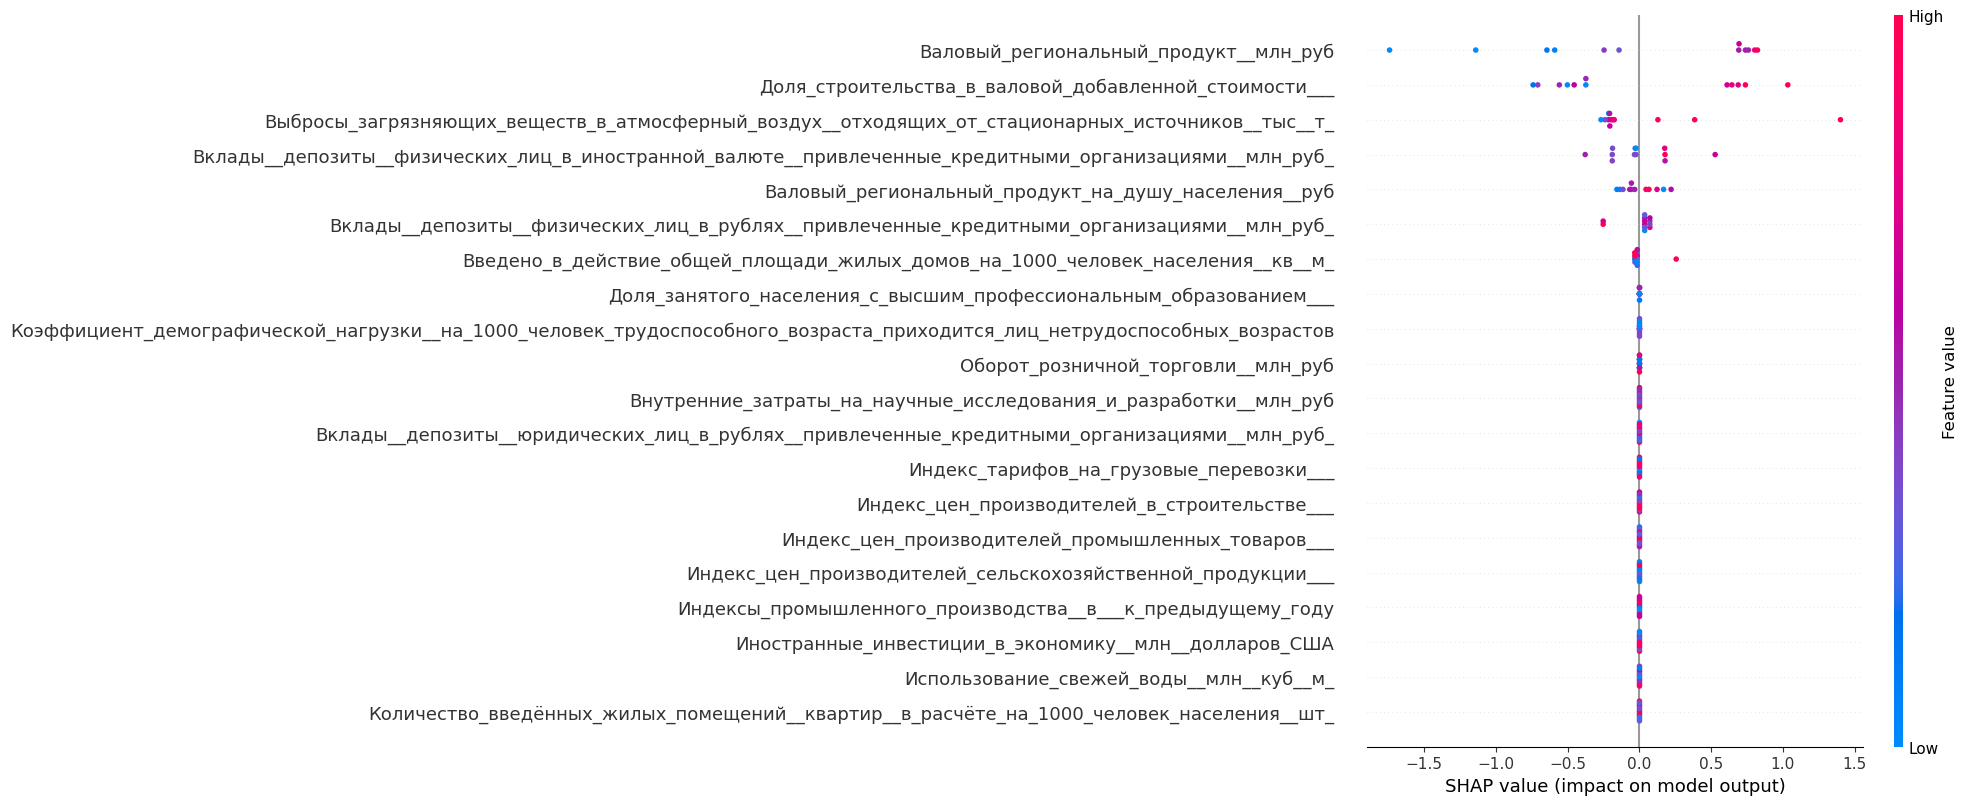

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


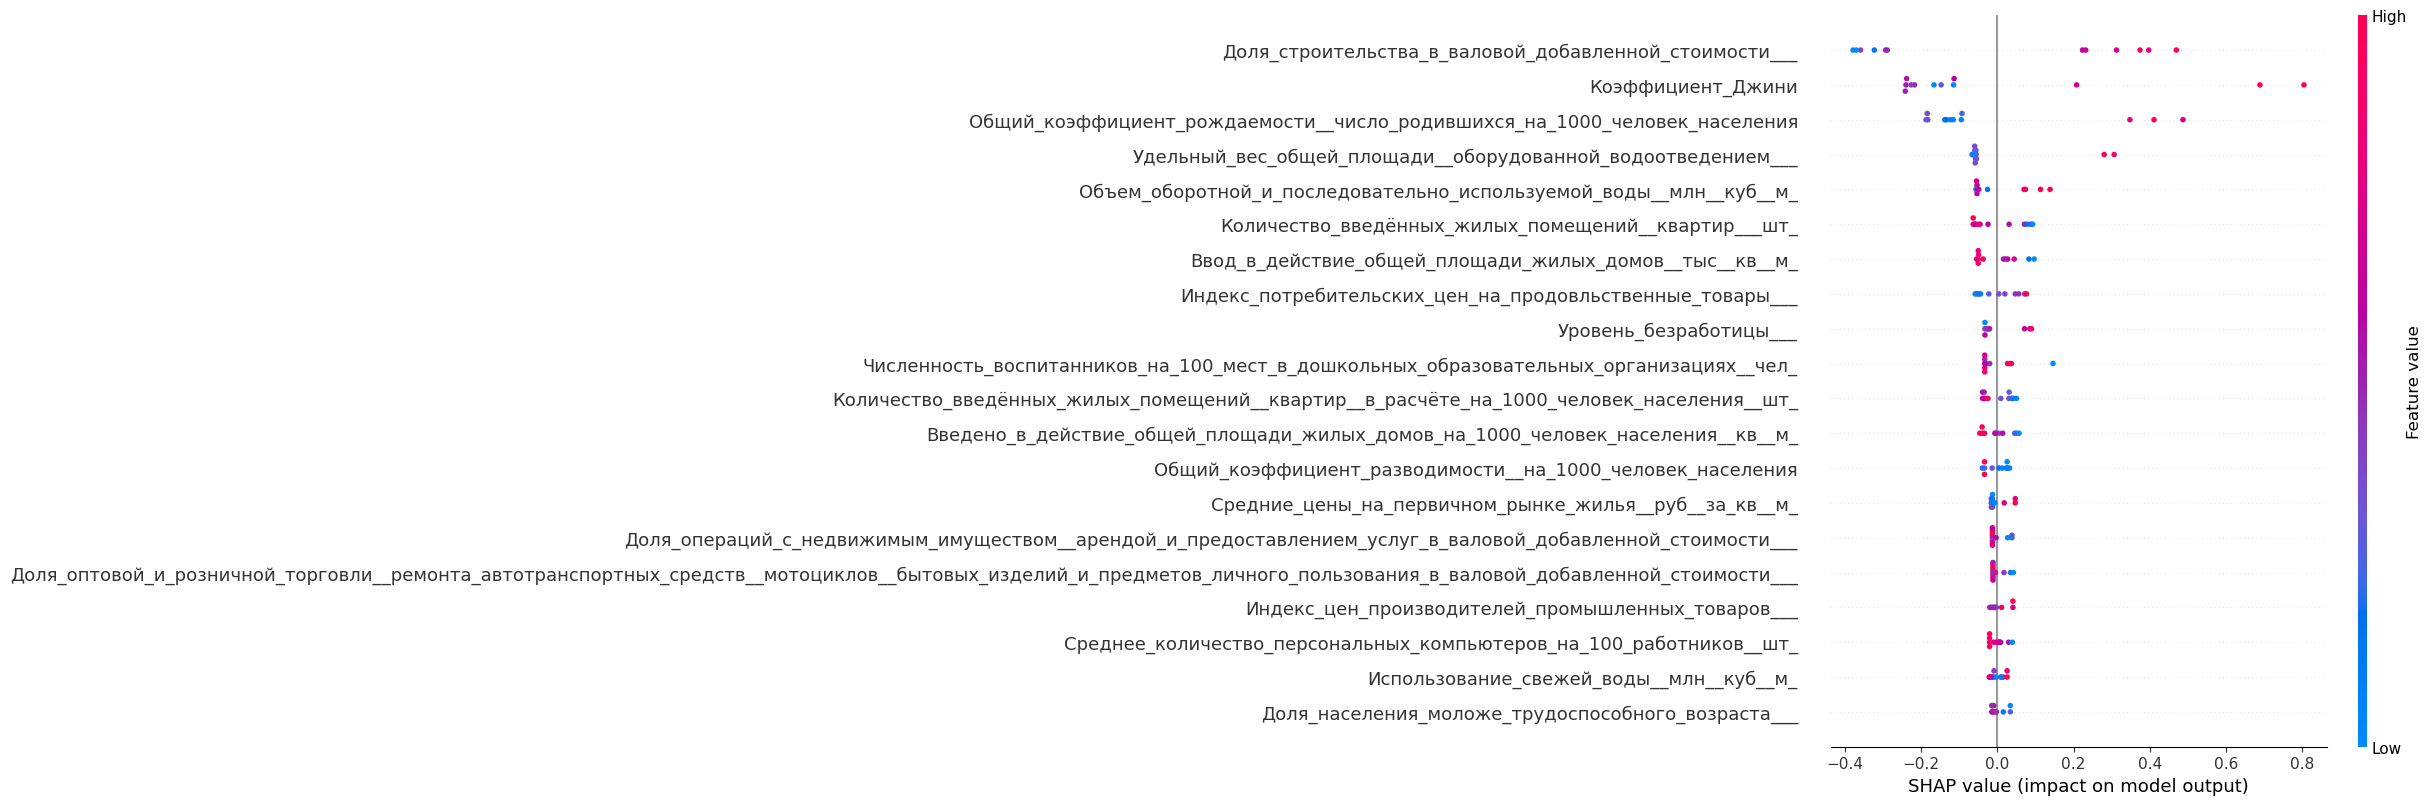

C:\Users\nikid\SHAP-значимость факторов 2025 г.xlsx

In [16]:
# Обучение модели для SHAP-анализа для target_1
model_sh_1 = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
model_sh_1.fit(X_1, Y_1)
explainer_1 = shap.Explainer(model_sh_1, X_1)
shap_values_1 = explainer_1(X_1)
shap.summary_plot(shap_values_1, X_1)

# Обучение модели для SHAP-анализа для target_2
model_sh_2 = ExtraTreesRegressor(n_estimators=150, max_depth=2, random_state=42)
model_sh_2.fit(X_2, Y_2)
explainer_2 = shap.Explainer(model_sh_2, X_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2, X_2)

# Расчёт средней важности факторов на основе SHAP-анализа
importance_1 = pd.DataFrame({
    "Фактор": X_1.columns,
    "Важность": shap_values_1.values.mean(axis=0)
})
importance_2 = pd.DataFrame({
    "Фактор": X_2.columns,
    "Важность": shap_values_2.values.mean(axis=0)
})

grouped_importance_1 = importance_1.groupby("Фактор", as_index=False)["Важность"].mean()
grouped_importance_2 = importance_2.groupby("Фактор", as_index=False)["Важность"].mean()
filtered_importance_1 = grouped_importance_1[grouped_importance_1["Важность"] != 0].sort_values(by="Важность", ascending=False)
filtered_importance_2 = grouped_importance_2[grouped_importance_2["Важность"] != 0].sort_values(by="Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
with pd.ExcelWriter("SHAP-значимость факторов 2025 г.xlsx") as writer:
    filtered_importance_1.to_excel(writer, sheet_name="SHAP_для_ИвОК", index=False)
    filtered_importance_2.to_excel(writer, sheet_name="SHAP_для_ИвОК_на_душу", index=False)
FileLink("SHAP-значимость факторов 2025 г.xlsx")

## Расчёт композитных индексов для 2025 г.

In [17]:
# Извлекается список значимых факторов по SHAP-анализу
selected_features_1 = filtered_importance_1["Фактор"].tolist()
selected_features_2 = filtered_importance_2["Фактор"].tolist()

# Формирование таблицы для target_1 в длинном формате
df_comp1 = X_1.reset_index() 
df_comp1 = df_comp1[["Регион"] + selected_features_1]
df_comp1_long = pd.melt(df_comp1, id_vars="Регион", var_name="Показатель", value_name="Значение_2025")

# Объединение таблицы с важностью факторов
df_comp1_long = df_comp1_long.merge(filtered_importance_1, left_on="Показатель", right_on="Фактор", how="inner")
df_comp1_long = df_comp1_long[["Регион", "Показатель", "Значение_2025", "Важность"]]
df_comp1_long["Произведение"] = df_comp1_long["Значение_2025"] * df_comp1_long["Важность"]

# Формирование таблицы для target_2 в длинном формате
df_comp2 = X_2.reset_index()
df_comp2 = df_comp2[["Регион"] + selected_features_2]
df_comp2_long = pd.melt(df_comp2, id_vars="Регион", var_name="Показатель", value_name="Значение_2025")

# Объединение таблицы с важностью факторов
df_comp2_long = df_comp2_long.merge(filtered_importance_2, left_on="Показатель", right_on="Фактор", how="inner")
df_comp2_long = df_comp2_long[["Регион", "Показатель", "Значение_2025", "Важность"]]
df_comp2_long["Произведение"] = df_comp2_long["Значение_2025"] * df_comp2_long["Важность"]

# Группировка по региону: сумма произведений для target_1 
composite_index_1 = df_comp1_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_1 = composite_index_1.rename(columns={"Произведение": "Композитный_индекс_ИвОК"})
composite_index_1 = composite_index_1.sort_values(by="Композитный_индекс_ИвОК", ascending=False)

# Группировка по региону: сумма произведений для target_2
composite_index_2 = df_comp2_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_2 = composite_index_2.rename(columns={"Произведение": "Композитный_индекс_ИвОК_на_душу"})
composite_index_2 = composite_index_2.sort_values(by="Композитный_индекс_ИвОК_на_душу", ascending=False)

# Сохранение сводных таблиц в один Excel-файл
with pd.ExcelWriter("Композитный индекс по регионам 2025 г.xlsx") as writer:
    composite_index_1.to_excel(writer, sheet_name="ИвОК_Композитный индекс", index=False)
    composite_index_2.to_excel(writer, sheet_name="ИвОК на душу_Композитный индекс", index=False)
FileLink("Композитный индекс по регионам 2025 г.xlsx")

C:\Users\nikid\Композитный индекс по регионам 2025 г.xlsx

## Выбор модели МО перед SHAP-анализом для 2026 г.

In [18]:
# Фиксируется 2026 год для анализа
year_column = 2026


# Подготовка сводных таблиц для каждого целевого показателя
df_pivot_1 = prepare_data(df_forecast_pivot, target_to_exclude=target_2, year_column=year_column)
df_pivot_2 = prepare_data(df_forecast_pivot, target_to_exclude=target_1, year_column=year_column)

# Формируются признаки (X) и целевые переменные (Y)
X_1 = clean_column_names(df_pivot_1.drop(columns=[target_1]))
Y_1 = df_pivot_1[target_1]
X_2 = clean_column_names(df_pivot_2.drop(columns=[target_2]))
Y_2 = df_pivot_2[target_2]

# Разбиение данных для target_1
print("Оценка качества для целевой переменной №1 - ИвОК")
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_1
model_xgb1 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
rmse_xgb1, mae_xgb1, smape_xgb1 = evaluate_model(model_xgb1, X1_train, X1_test, Y1_train, Y1_test)

model_lgb1 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb1, mae_lgb1, smape_lgb1 = evaluate_model(model_lgb1, X1_train, X1_test, Y1_train, Y1_test)

model_et1 = ExtraTreesRegressor(n_estimators=200, max_depth=2, random_state=42)
rmse_et1, mae_et1, smape_et1 = evaluate_model(model_et1, X1_train, X1_test, Y1_train, Y1_test)

print(f"Target 1 ({target_1}):")
print(f"  XGBoost    - RMSE: {rmse_xgb1:.2f}, MAE: {mae_xgb1:.2f}, SMAPE: {smape_xgb1:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb1:.2f}, MAE: {mae_lgb1:.2f}, SMAPE: {smape_lgb1:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et1:.2f}, MAE: {mae_et1:.2f}, SMAPE: {smape_et1:.2f}%")

# Разбиение данных для target_2
print("Оценка качества для целевой переменной №2 - ИвОК на д.н.")
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_2
model_xgb2 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
rmse_xgb2, mae_xgb2, smape_xgb2 = evaluate_model(model_xgb2, X2_train, X2_test, Y2_train, Y2_test)

model_lgb2 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb2, mae_lgb2, smape_lgb2 = evaluate_model(model_lgb2, X2_train, X2_test, Y2_train, Y2_test)

model_et2 = ExtraTreesRegressor(n_estimators=200, max_depth=2, random_state=42)
rmse_et2, mae_et2, smape_et2 = evaluate_model(model_et2, X2_train, X2_test, Y2_train, Y2_test)

print(f"Target 2 ({target_2}):")
print(f"  XGBoost    - RMSE: {rmse_xgb2:.2f}, MAE: {mae_xgb2:.2f}, SMAPE: {smape_xgb2:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb2:.2f}, MAE: {mae_lgb2:.2f}, SMAPE: {smape_lgb2:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et2:.2f}, MAE: {mae_et2:.2f}, SMAPE: {smape_et2:.2f}%")

Оценка качества для целевой переменной №1 - ИвОК
Target 1 (Инвестиции в основной капитал, млн руб):
  XGBoost    - RMSE: 1.12, MAE: 0.85, SMAPE: 7.23%
  LightGBM   - RMSE: 0.98, MAE: 0.93, SMAPE: 7.60%
  ExtraTrees - RMSE: 0.71, MAE: 0.66, SMAPE: 5.45%
Оценка качества для целевой переменной №2 - ИвОК на д.н.
Target 2 (Инвестиции в основной капитал на душу населения, руб):
  XGBoost    - RMSE: 0.84, MAE: 0.61, SMAPE: 4.57%
  LightGBM   - RMSE: 1.00, MAE: 0.95, SMAPE: 7.79%
  ExtraTrees - RMSE: 1.31, MAE: 1.11, SMAPE: 9.03%


## SHAP-анализ для 2026 г.

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


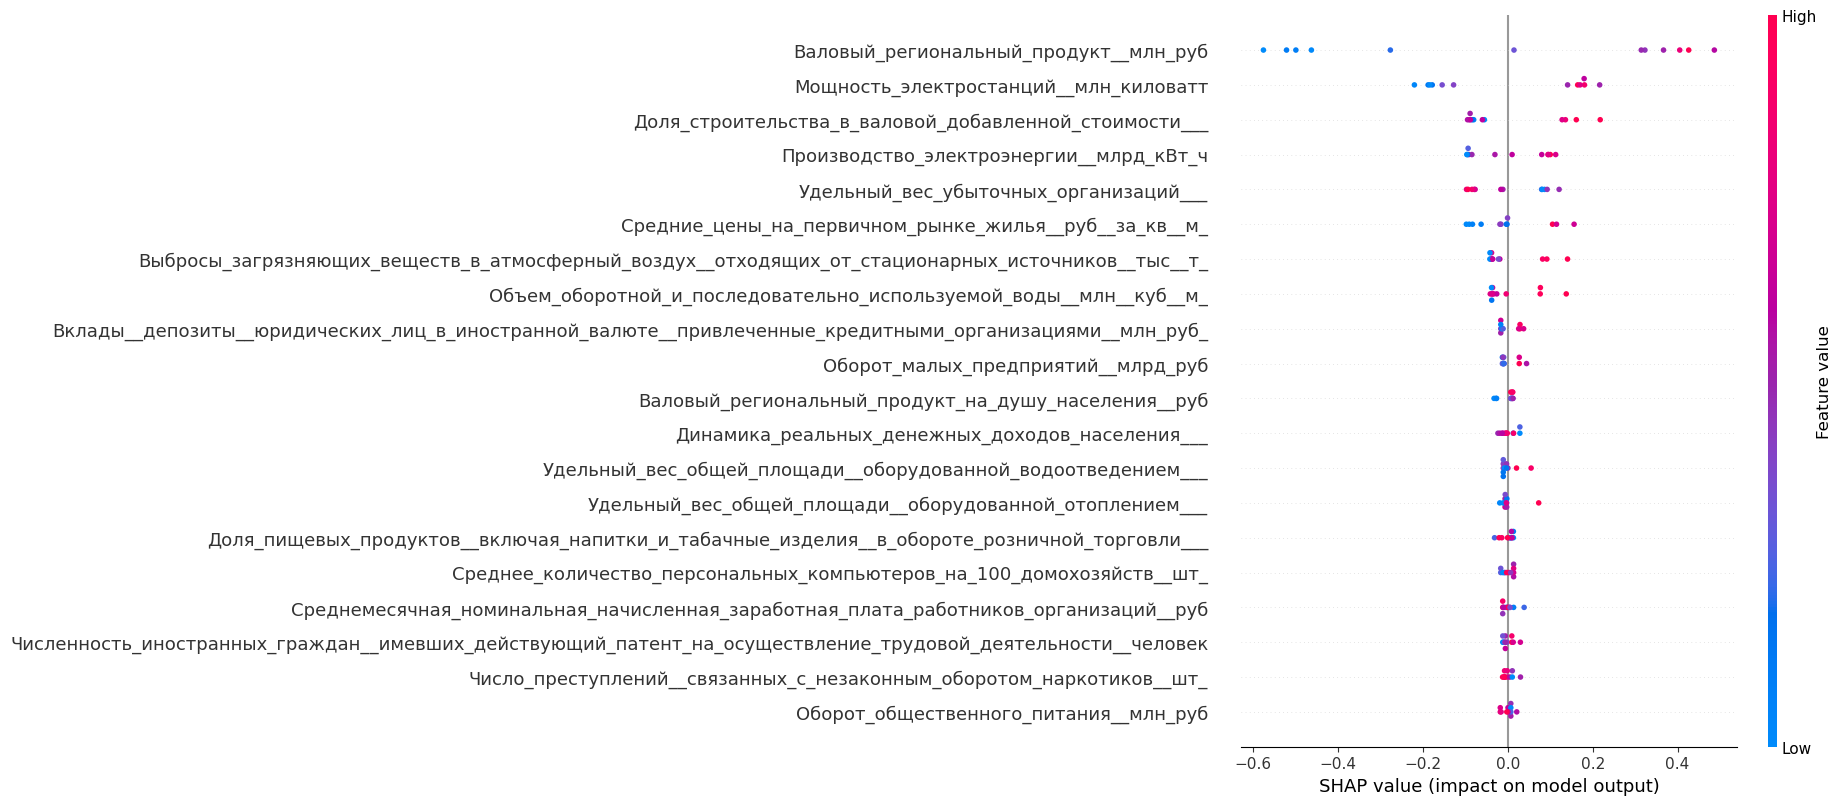

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


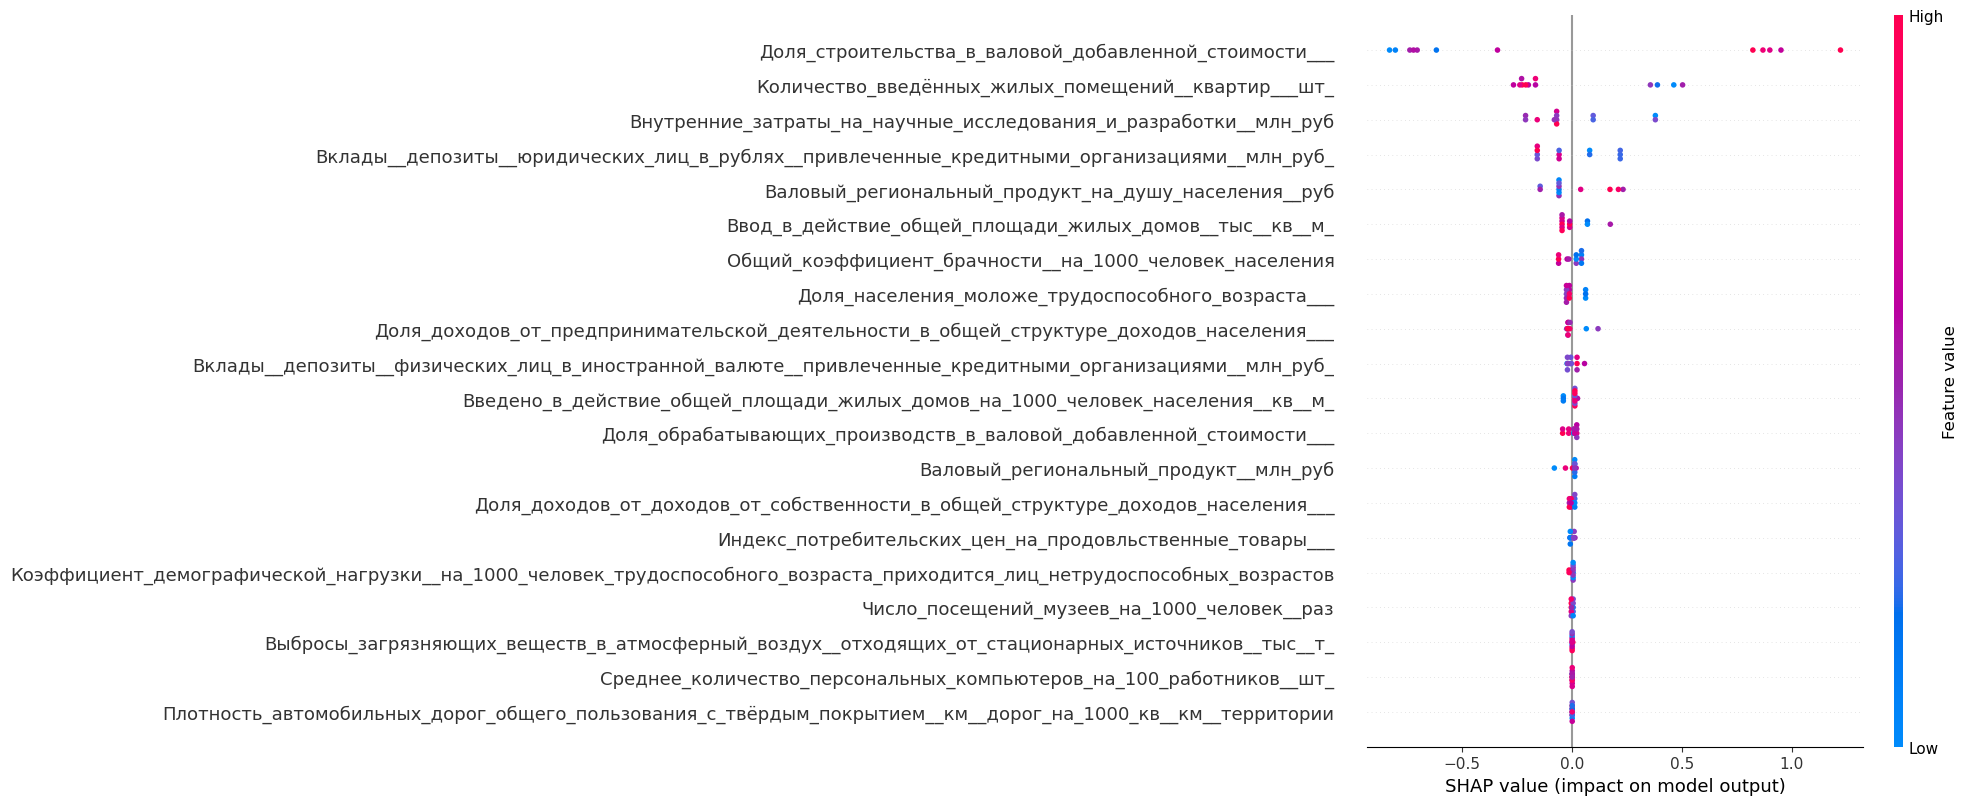

C:\Users\nikid\SHAP-значимость факторов 2026 г.xlsx

In [19]:
# Обучение модели для SHAP-анализа для target_1
model_sh_1 = ExtraTreesRegressor(n_estimators=200, max_depth=2, random_state=42)
model_sh_1.fit(X_1, Y_1)
explainer_1 = shap.Explainer(model_sh_1, X_1)
shap_values_1 = explainer_1(X_1)
shap.summary_plot(shap_values_1, X_1)

# Обучение модели для SHAP-анализа для target_2
model_sh_2 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
model_sh_2.fit(X_2, Y_2)
explainer_2 = shap.Explainer(model_sh_2, X_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2, X_2)

# Расчёт средней важности факторов на основе SHAP-анализа
importance_1 = pd.DataFrame({
    "Фактор": X_1.columns,
    "Важность": shap_values_1.values.mean(axis=0)
})
importance_2 = pd.DataFrame({
    "Фактор": X_2.columns,
    "Важность": shap_values_2.values.mean(axis=0)
})

grouped_importance_1 = importance_1.groupby("Фактор", as_index=False)["Важность"].mean()
grouped_importance_2 = importance_2.groupby("Фактор", as_index=False)["Важность"].mean()
filtered_importance_1 = grouped_importance_1[grouped_importance_1["Важность"] != 0].sort_values(by="Важность", ascending=False)
filtered_importance_2 = grouped_importance_2[grouped_importance_2["Важность"] != 0].sort_values(by="Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
with pd.ExcelWriter("SHAP-значимость факторов 2026 г.xlsx") as writer:
    filtered_importance_1.to_excel(writer, sheet_name="SHAP_для_ИвОК", index=False)
    filtered_importance_2.to_excel(writer, sheet_name="SHAP_для_ИвОК_на_душу", index=False)
FileLink("SHAP-значимость факторов 2026 г.xlsx")

## Расчёт композитных индексов для 2026 г.

In [20]:
# Извлекается список значимых факторов по SHAP-анализу
selected_features_1 = filtered_importance_1["Фактор"].tolist()
selected_features_2 = filtered_importance_2["Фактор"].tolist()

# Формирование таблицы для target_1 в длинном формате
df_comp1 = X_1.reset_index() 
df_comp1 = df_comp1[["Регион"] + selected_features_1]
df_comp1_long = pd.melt(df_comp1, id_vars="Регион", var_name="Показатель", value_name="Значение_2026")

# Объединение таблицы с важностью факторов
df_comp1_long = df_comp1_long.merge(filtered_importance_1, left_on="Показатель", right_on="Фактор", how="inner")
df_comp1_long = df_comp1_long[["Регион", "Показатель", "Значение_2026", "Важность"]]
df_comp1_long["Произведение"] = df_comp1_long["Значение_2026"] * df_comp1_long["Важность"]

# Формирование таблицы для target_2 в длинном формате
df_comp2 = X_2.reset_index()
df_comp2 = df_comp2[["Регион"] + selected_features_2]
df_comp2_long = pd.melt(df_comp2, id_vars="Регион", var_name="Показатель", value_name="Значение_2026")

# Объединение таблицы с важностью факторов
df_comp2_long = df_comp2_long.merge(filtered_importance_2, left_on="Показатель", right_on="Фактор", how="inner")
df_comp2_long = df_comp2_long[["Регион", "Показатель", "Значение_2026", "Важность"]]
df_comp2_long["Произведение"] = df_comp2_long["Значение_2026"] * df_comp2_long["Важность"]

# Группировка по региону: сумма произведений для target_1 
composite_index_1 = df_comp1_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_1 = composite_index_1.rename(columns={"Произведение": "Композитный_индекс_ИвОК"})
composite_index_1 = composite_index_1.sort_values(by="Композитный_индекс_ИвОК", ascending=False)

# Группировка по региону: сумма произведений для target_2
composite_index_2 = df_comp2_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_2 = composite_index_2.rename(columns={"Произведение": "Композитный_индекс_ИвОК_на_душу"})
composite_index_2 = composite_index_2.sort_values(by="Композитный_индекс_ИвОК_на_душу", ascending=False)

# Сохранение сводных таблиц в один Excel-файл
with pd.ExcelWriter("Композитный индекс по регионам 2026 г.xlsx") as writer:
    composite_index_1.to_excel(writer, sheet_name="ИвОК_Композитный индекс", index=False)
    composite_index_2.to_excel(writer, sheet_name="ИвОК на душу_Композитный индекс", index=False)
FileLink("Композитный индекс по регионам 2026 г.xlsx")

C:\Users\nikid\Композитный индекс по регионам 2026 г.xlsx

## Выбор модели МО перед SHAP-анализом для 2027 г.

In [21]:
# Фиксируется 2027 год для анализа
year_column = 2027


# Подготовка сводных таблиц для каждого целевого показателя
df_pivot_1 = prepare_data(df_forecast_pivot, target_to_exclude=target_2, year_column=year_column)
df_pivot_2 = prepare_data(df_forecast_pivot, target_to_exclude=target_1, year_column=year_column)

# Формируются признаки (X) и целевые переменные (Y)
X_1 = clean_column_names(df_pivot_1.drop(columns=[target_1]))
Y_1 = df_pivot_1[target_1]
X_2 = clean_column_names(df_pivot_2.drop(columns=[target_2]))
Y_2 = df_pivot_2[target_2]

# Разбиение данных для target_1
print("Оценка качества для целевой переменной №1 - ИвОК")
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1, Y_1, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_1
model_xgb1 = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
rmse_xgb1, mae_xgb1, smape_xgb1 = evaluate_model(model_xgb1, X1_train, X1_test, Y1_train, Y1_test)

model_lgb1 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb1, mae_lgb1, smape_lgb1 = evaluate_model(model_lgb1, X1_train, X1_test, Y1_train, Y1_test)

model_et1 = ExtraTreesRegressor(n_estimators=150, max_depth=3, random_state=42)
rmse_et1, mae_et1, smape_et1 = evaluate_model(model_et1, X1_train, X1_test, Y1_train, Y1_test)

print(f"Target 1 ({target_1}):")
print(f"  XGBoost    - RMSE: {rmse_xgb1:.2f}, MAE: {mae_xgb1:.2f}, SMAPE: {smape_xgb1:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb1:.2f}, MAE: {mae_lgb1:.2f}, SMAPE: {smape_lgb1:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et1:.2f}, MAE: {mae_et1:.2f}, SMAPE: {smape_et1:.2f}%")

# Разбиение данных для target_2
print("Оценка качества для целевой переменной №2 - ИвОК на д.н.")
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)

# Обучение и оценка моделей для target_2
model_xgb2 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
rmse_xgb2, mae_xgb2, smape_xgb2 = evaluate_model(model_xgb2, X2_train, X2_test, Y2_train, Y2_test)

model_lgb2 = lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)
rmse_lgb2, mae_lgb2, smape_lgb2 = evaluate_model(model_lgb2, X2_train, X2_test, Y2_train, Y2_test)

model_et2 = ExtraTreesRegressor(n_estimators=500, max_depth=4, random_state=42)
rmse_et2, mae_et2, smape_et2 = evaluate_model(model_et2, X2_train, X2_test, Y2_train, Y2_test)

print(f"Target 2 ({target_2}):")
print(f"  XGBoost    - RMSE: {rmse_xgb2:.2f}, MAE: {mae_xgb2:.2f}, SMAPE: {smape_xgb2:.2f}%")
print(f"  LightGBM   - RMSE: {rmse_lgb2:.2f}, MAE: {mae_lgb2:.2f}, SMAPE: {smape_lgb2:.2f}%")
print(f"  ExtraTrees - RMSE: {rmse_et2:.2f}, MAE: {mae_et2:.2f}, SMAPE: {smape_et2:.2f}%")

Оценка качества для целевой переменной №1 - ИвОК
Target 1 (Инвестиции в основной капитал, млн руб):
  XGBoost    - RMSE: 0.86, MAE: 0.81, SMAPE: 7.06%
  LightGBM   - RMSE: 0.59, MAE: 0.46, SMAPE: 3.86%
  ExtraTrees - RMSE: 0.48, MAE: 0.46, SMAPE: 3.83%
Оценка качества для целевой переменной №2 - ИвОК на д.н.
Target 2 (Инвестиции в основной капитал на душу населения, руб):
  XGBoost    - RMSE: 0.77, MAE: 0.64, SMAPE: 4.98%
  LightGBM   - RMSE: 0.55, MAE: 0.51, SMAPE: 4.11%
  ExtraTrees - RMSE: 0.72, MAE: 0.67, SMAPE: 5.42%


## SHAP-анализ для 2027 г.

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


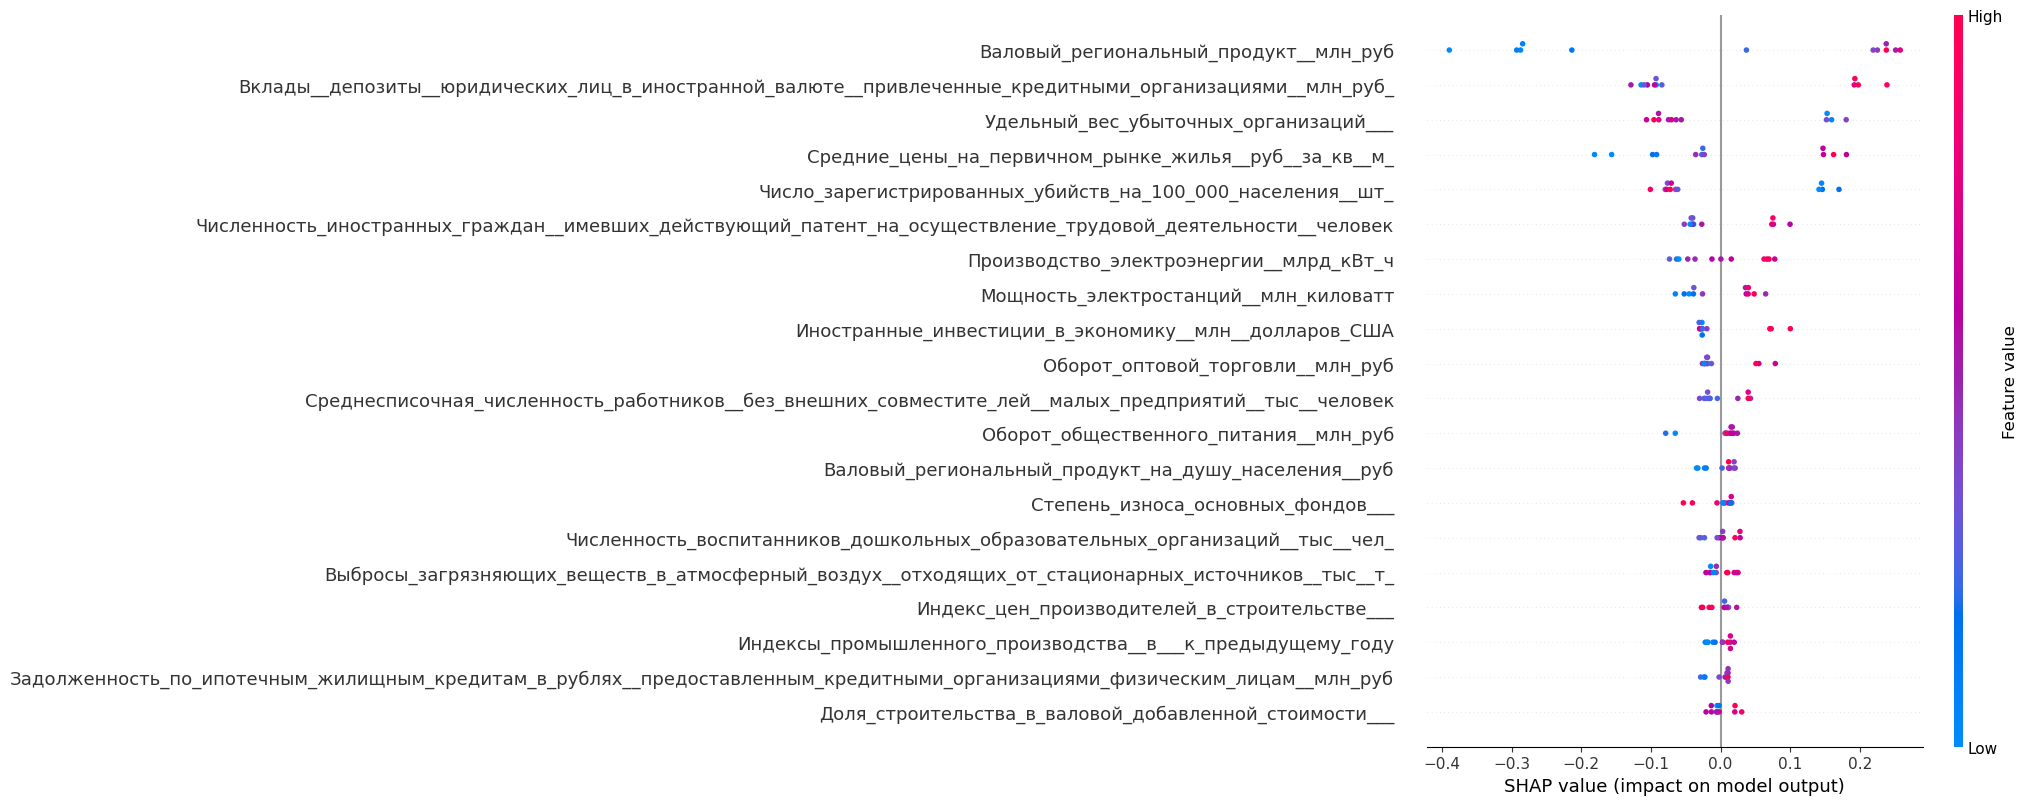

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


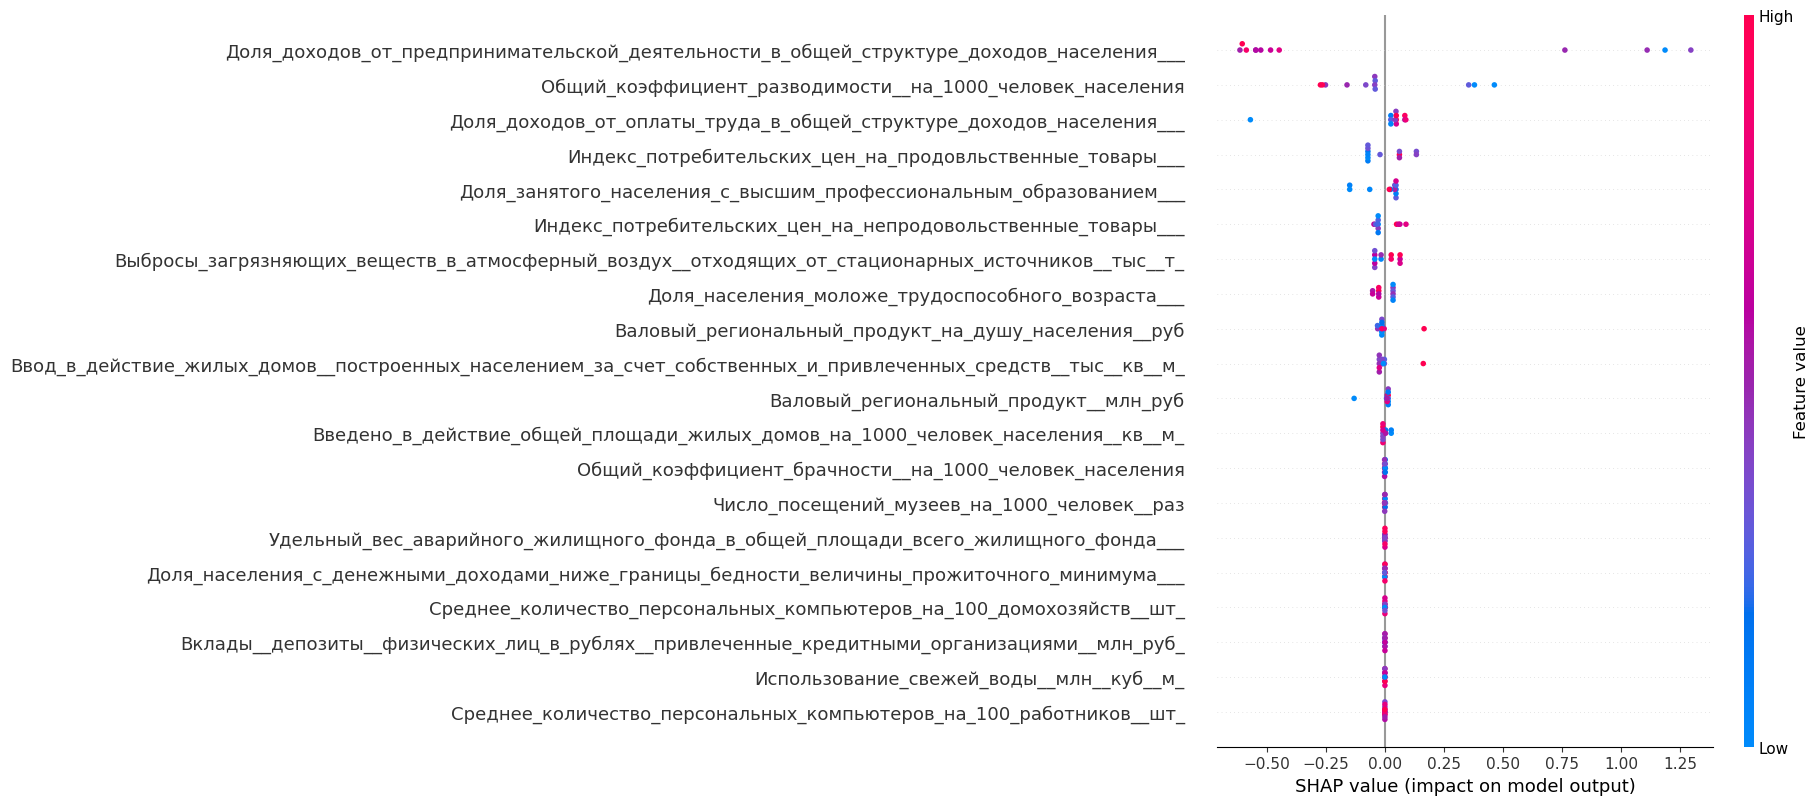

C:\Users\nikid\SHAP-значимость факторов 2027 г.xlsx

In [22]:
# Обучение модели для SHAP-анализа для target_1
model_sh_1 = ExtraTreesRegressor(n_estimators=150, max_depth=3, random_state=42)
model_sh_1.fit(X_1, Y_1)
explainer_1 = shap.Explainer(model_sh_1, X_1)
shap_values_1 = explainer_1(X_1)
shap.summary_plot(shap_values_1, X_1)

# Обучение модели для SHAP-анализа для target_2
model_sh_2 = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
model_sh_2.fit(X_2, Y_2)
explainer_2 = shap.Explainer(model_sh_2, X_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2, X_2)

# Расчёт средней важности факторов на основе SHAP-анализа
importance_1 = pd.DataFrame({
    "Фактор": X_1.columns,
    "Важность": shap_values_1.values.mean(axis=0)
})
importance_2 = pd.DataFrame({
    "Фактор": X_2.columns,
    "Важность": shap_values_2.values.mean(axis=0)
})

grouped_importance_1 = importance_1.groupby("Фактор", as_index=False)["Важность"].mean()
grouped_importance_2 = importance_2.groupby("Фактор", as_index=False)["Важность"].mean()
filtered_importance_1 = grouped_importance_1[grouped_importance_1["Важность"] != 0].sort_values(by="Важность", ascending=False)
filtered_importance_2 = grouped_importance_2[grouped_importance_2["Важность"] != 0].sort_values(by="Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
with pd.ExcelWriter("SHAP-значимость факторов 2027 г.xlsx") as writer:
    filtered_importance_1.to_excel(writer, sheet_name="SHAP_для_ИвОК", index=False)
    filtered_importance_2.to_excel(writer, sheet_name="SHAP_для_ИвОК_на_душу", index=False)
FileLink("SHAP-значимость факторов 2027 г.xlsx")

## Расчёт композитных индексов для 2027 г.

In [23]:
# Извлекается список значимых факторов по SHAP-анализу
selected_features_1 = filtered_importance_1["Фактор"].tolist()
selected_features_2 = filtered_importance_2["Фактор"].tolist()

# Формирование таблицы для target_1 в длинном формате
df_comp1 = X_1.reset_index() 
df_comp1 = df_comp1[["Регион"] + selected_features_1]
df_comp1_long = pd.melt(df_comp1, id_vars="Регион", var_name="Показатель", value_name="Значение_2027")

# Объединение таблицы с важностью факторов
df_comp1_long = df_comp1_long.merge(filtered_importance_1, left_on="Показатель", right_on="Фактор", how="inner")
df_comp1_long = df_comp1_long[["Регион", "Показатель", "Значение_2027", "Важность"]]
df_comp1_long["Произведение"] = df_comp1_long["Значение_2027"] * df_comp1_long["Важность"]

# Формирование таблицы для target_2 в длинном формате
df_comp2 = X_2.reset_index()
df_comp2 = df_comp2[["Регион"] + selected_features_2]
df_comp2_long = pd.melt(df_comp2, id_vars="Регион", var_name="Показатель", value_name="Значение_2027")

# Объединение таблицы с важностью факторов
df_comp2_long = df_comp2_long.merge(filtered_importance_2, left_on="Показатель", right_on="Фактор", how="inner")
df_comp2_long = df_comp2_long[["Регион", "Показатель", "Значение_2027", "Важность"]]
df_comp2_long["Произведение"] = df_comp2_long["Значение_2027"] * df_comp2_long["Важность"]

# Группировка по региону: сумма произведений для target_1 
composite_index_1 = df_comp1_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_1 = composite_index_1.rename(columns={"Произведение": "Композитный_индекс_ИвОК"})
composite_index_1 = composite_index_1.sort_values(by="Композитный_индекс_ИвОК", ascending=False)

# Группировка по региону: сумма произведений для target_2
composite_index_2 = df_comp2_long.groupby("Регион", as_index=False)["Произведение"].sum()
composite_index_2 = composite_index_2.rename(columns={"Произведение": "Композитный_индекс_ИвОК_на_душу"})
composite_index_2 = composite_index_2.sort_values(by="Композитный_индекс_ИвОК_на_душу", ascending=False)

# Сохранение сводных таблиц в один Excel-файл
with pd.ExcelWriter("Композитный индекс по регионам 2027 г.xlsx") as writer:
    composite_index_1.to_excel(writer, sheet_name="ИвОК_Композитный индекс", index=False)
    composite_index_2.to_excel(writer, sheet_name="ИвОК на душу_Композитный индекс", index=False)
FileLink("Композитный индекс по регионам 2027 г.xlsx")

C:\Users\nikid\Композитный индекс по регионам 2027 г.xlsx

# Проведение SHAP-анализа на 2025-2027 гг. по группам регионов для разработки рекомендаций

## Выбор модели МО перед SHAP-анализом для Центра притяжения (г. Санкт-Петербург)

In [25]:
# Фиксируются анализируемые годы
years = [2025, 2026, 2027]

# Строится таблица с интересующими столбцами
df = df_forecast_pivot[['Регион', 'Показатель'] + years]
df_wide = df.pivot(index='Регион', columns='Показатель', values=years)


# Преобразуем названия колонок в вид {Показатель_Год}, что необходимо для корректной работы кода при анализе нескольких лет
new_cols = []
for year, metric in df_wide.columns.to_flat_index():
    clean = metric.replace(',', '').replace(' ', '_')
    new_cols.append(f"{clean}_{year}")
df_wide.columns = new_cols

# Названия признаков приводятся к виду колонок
pref1 = target_1.replace(',', '').replace(' ', '_')
pref2 = target_2.replace(',', '').replace(' ', '_')

# Определяются столбцы с целевыми переменными
t1_cols = [f"{pref1}_{y}" for y in years]
t2_cols = [f"{pref2}_{y}" for y in years]

# Остальные столбцы это независимые переменные
feature_cols = [c for c in df_wide.columns if c not in (t1_cols + t2_cols)]

# Таблица разделяется на матрицы признаков
X_all = df_wide[feature_cols]
Y_all = df_wide[t1_cols + t2_cols]


# Модель обучается на данных всех регионов, а тестируется на данных СПб
region = "г.Санкт-Петербург"
if region not in X_all.index:
    raise ValueError(f"Регион {region} не найден в данных.")
X_train = X_all.drop(index=region)
Y_train = Y_all.drop(index=region)
X_test  = X_all.loc[[region]]
Y_test  = Y_all.loc[[region]]

# Создаются модели МО
models = {
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)),
    "ExtraTrees": MultiOutputRegressor(ExtraTreesRegressor(n_estimators=150, max_depth=2, random_state=42))
}

# Обучение, предсказывание, вывод метрик ошибок
print(f"Оценка качества для региона/-ов: {region}")
for name, base in models.items():
    model = base
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)  
    y_true = Y_test.iloc[0].to_numpy()
    y_pred = Y_pred.flatten()
    
    rmse, mae, smape = calculate_metrics(y_true, y_pred)
    print(f"  {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, SMAPE: {smape:.2f}%")

Оценка качества для региона/-ов: г.Санкт-Петербург
  XGBoost - RMSE: 0.95, MAE: 0.87, SMAPE: 7.03%
  LightGBM - RMSE: 1.28, MAE: 1.12, SMAPE: 9.30%
  ExtraTrees - RMSE: 1.13, MAE: 0.95, SMAPE: 7.93%


## SHAP-анализ для 2025-2027 гг. для Центра притяжения (г. Санкт-Петербург)

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\nikid\AppData\Local\Temp\ipykernel_12736\2409169918.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


C:\Users\nikid\SHAP-значимость факторов в Центре притяжения 2025-2027 гг.xlsx

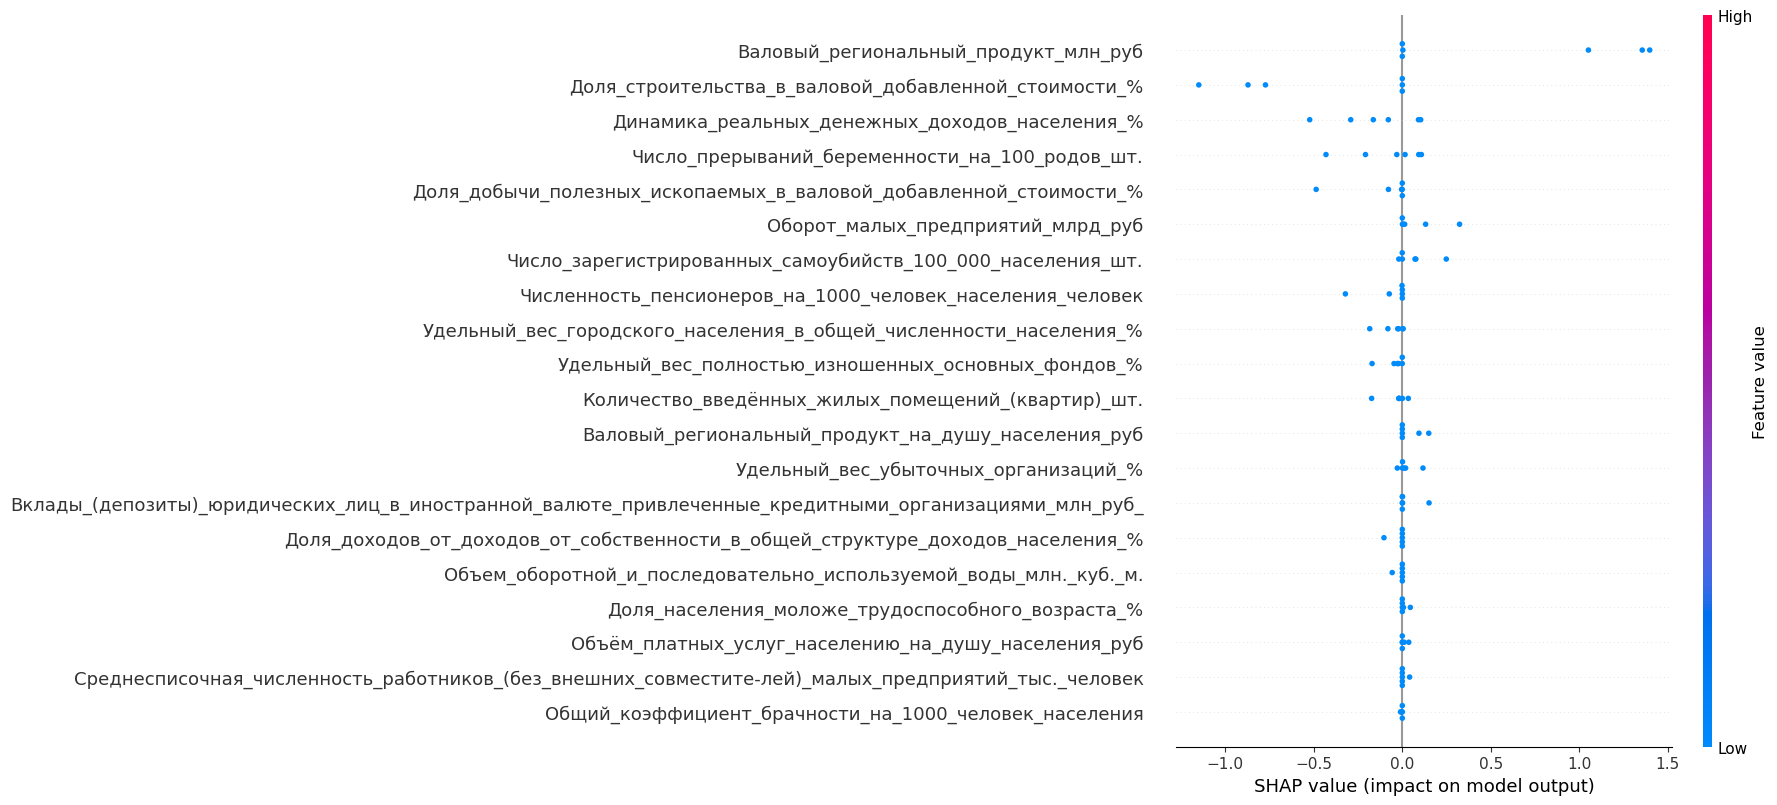

In [28]:
# Агрегация годовых колонок для обучающей и тестовой выборки
Xtr_agg = aggregate_years(X_train)
Xte_agg = aggregate_years(X_test)

# Обучение модели
best = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
best.fit(Xtr_agg, Y_train)

# Проводится SHAP-анализ в рамках каждого года и целевой переменной
sh_list = []
for est in best.estimators_:
    expl = shap.TreeExplainer(est)
    sh = expl.shap_values(Xte_agg)    
    sh_list.append(sh)

# Все массивы с SHAP-значениями объединяются в один
sh_arr = np.stack(sh_list, axis=0)    

# Построение графика SHAP-анализа
X_rep = pd.concat([Xte_agg]*len(sh_list), ignore_index=True)
sh_plot = sh_arr.reshape(-1, sh_arr.shape[2])
shap.summary_plot(sh_plot, X_rep, feature_names=Xte_agg.columns, show=False)
plt.tight_layout()

# SHAP-значения усредняются, заносятся в таблицу и исключаются незначимые факторы
mean_sh = sh_arr.mean(axis=(0,1))
imp = pd.DataFrame({
    "Фактор": Xte_agg.columns,
    "Важность": mean_sh})
imp = imp[imp["Важность"] != 0].sort_values("Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
imp.to_excel("SHAP-значимость факторов в Центре притяжения 2025-2027 гг.xlsx", index=False)
FileLink("SHAP-значимость факторов в Центре притяжения 2025-2027 гг.xlsx")

## Выбор модели МО перед SHAP-анализом для Лидеров (Мурманская и Новгородская области)

In [29]:
# Фиксируются анализируемые годы
years = [2025, 2026, 2027]

# Строится таблица с интересующими столбцами
df = df_forecast_pivot[['Регион', 'Показатель'] + years]
df_wide = df.pivot(index='Регион', columns='Показатель', values=years)

# Преобразуем названия колонок в вид {Показатель_Год}, что необходимо для корректной работы кода при анализе нескольких лет
new_cols = []
for year, metric in df_wide.columns.to_flat_index():
    clean = metric.replace(',', '').replace(' ', '_')
    new_cols.append(f"{clean}_{year}")
df_wide.columns = new_cols

# Названия признаков приводятся к виду колонок
pref1 = target_1.replace(',', '').replace(' ', '_')
pref2 = target_2.replace(',', '').replace(' ', '_')

# Определяются столбцы с целевыми переменными
t1_cols = [f"{pref1}_{y}" for y in years]
t2_cols = [f"{pref2}_{y}" for y in years]

# Остальные столбцы это независимые переменные
feature_cols = [c for c in df_wide.columns if c not in (t1_cols + t2_cols)]

# Таблица разделяется на матрицы признаков
X_all = df_wide[feature_cols]
Y_all = df_wide[t1_cols + t2_cols]

# Регионы для тестирования
test_regions = ["Мурманская область", "Новгородская область"]

# Создаются модели МО
models = {
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, max_depth=3, random_state=42, verbose=-1)),
    "ExtraTrees": MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=5, random_state=42))
}

# Обучение, предсказывание, вывод метрик ошибок для каждого тестового региона
for region in test_regions:
    if region not in X_all.index:
        raise ValueError(f"Регион {region} не найден в данных.")
    X_train = X_all.drop(index=region)
    Y_train = Y_all.drop(index=region)
    X_test  = X_all.loc[[region]]
    Y_test  = Y_all.loc[[region]]

    print(f"Оценка качества для региона: {region}")
    for name, base in models.items():
        model = base
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test) 
        y_true = Y_test.iloc[0].to_numpy()
        y_pred = Y_pred.flatten()
        
        rmse, mae, smape = calculate_metrics(y_true, y_pred)
        print(f"  {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, SMAPE: {smape:.2f}%")

Оценка качества для региона: Мурманская область
  XGBoost - RMSE: 0.74, MAE: 0.66, SMAPE: 5.00%
  LightGBM - RMSE: 1.28, MAE: 1.28, SMAPE: 9.91%
  ExtraTrees - RMSE: 1.32, MAE: 1.05, SMAPE: 8.26%
Оценка качества для региона: Новгородская область
  XGBoost - RMSE: 1.52, MAE: 1.30, SMAPE: 11.65%
  LightGBM - RMSE: 2.18, MAE: 2.13, SMAPE: 18.53%
  ExtraTrees - RMSE: 1.64, MAE: 1.61, SMAPE: 14.32%


## SHAP-анализ для 2025-2027 гг. для Лидеров (Мурманская и Новгородская области)

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\nikid\AppData\Local\Temp\ipykernel_12736\3745668447.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


C:\Users\nikid\SHAP-значимость факторов для Лидеров 2025-2027 гг.xlsx

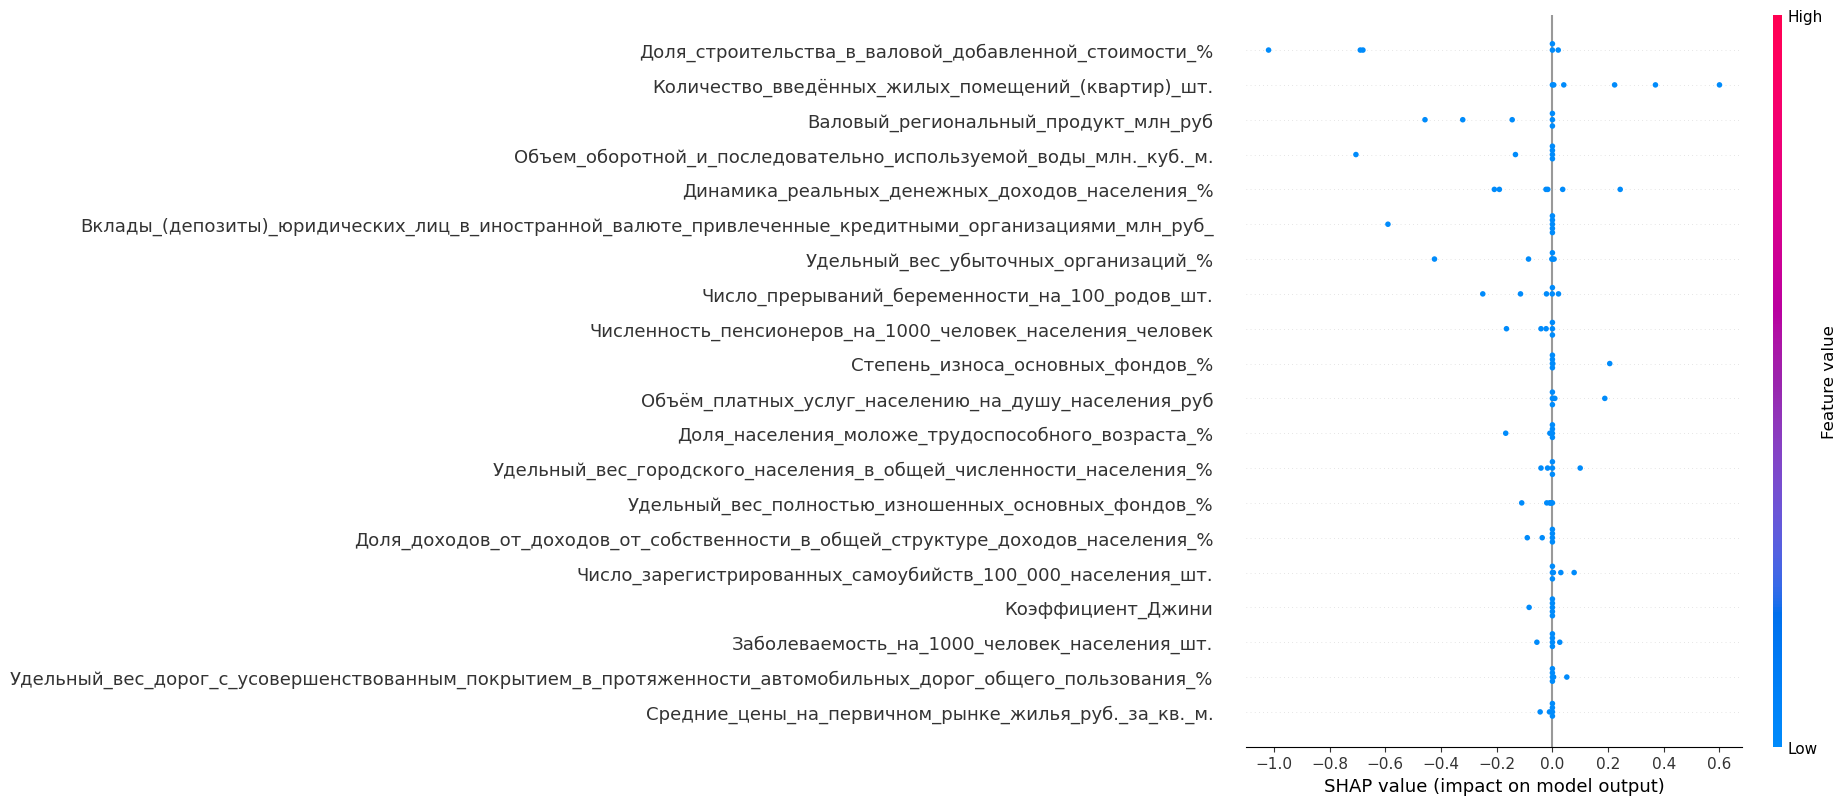

In [30]:
# Агрегация годовых колонок для обучающей и тестовой выборки
Xtr_agg = aggregate_years(X_train)
Xte_agg = aggregate_years(X_test)

# Обучение модели
best = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42))
best.fit(Xtr_agg, Y_train)

# Проводится SHAP-анализ в рамках каждого года и целевой переменной
sh_list = []
for est in best.estimators_:
    expl = shap.TreeExplainer(est)
    sh = expl.shap_values(Xte_agg)    
    sh_list.append(sh)

# Все массивы с SHAP-значениями объединяются в один
sh_arr = np.stack(sh_list, axis=0)    

# Построение графика SHAP-анализа
X_rep = pd.concat([Xte_agg]*len(sh_list), ignore_index=True)
sh_plot = sh_arr.reshape(-1, sh_arr.shape[2])
shap.summary_plot(sh_plot, X_rep, feature_names=Xte_agg.columns, show=False)
plt.tight_layout()

# SHAP-значения усредняются, заносятся в таблицу и исключаются незначимые факторы
mean_sh = sh_arr.mean(axis=(0,1))
imp = pd.DataFrame({
    "Фактор": Xte_agg.columns,
    "Важность": mean_sh})
imp = imp[imp["Важность"] != 0].sort_values("Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
imp.to_excel("SHAP-значимость факторов для Лидеров 2025-2027 гг.xlsx", index=False)
FileLink("SHAP-значимость факторов для Лидеров 2025-2027 гг.xlsx")

## Выбор модели МО перед SHAP-анализом для Ключевых игроков (Ленинградская и Вологодская области)

In [31]:
# Фиксируются анализируемые годы
years = [2025, 2026, 2027]

# Строится таблица с интересующими столбцами
df = df_forecast_pivot[['Регион', 'Показатель'] + years]
df_wide = df.pivot(index='Регион', columns='Показатель', values=years)

# Преобразуем названия колонок в вид {Показатель_Год}, что необходимо для корректной работы кода при анализе нескольких лет
new_cols = []
for year, metric in df_wide.columns.to_flat_index():
    clean = metric.replace(',', '').replace(' ', '_')
    new_cols.append(f"{clean}_{year}")
df_wide.columns = new_cols

# Названия признаков приводятся к виду колонок
pref1 = target_1.replace(',', '').replace(' ', '_')
pref2 = target_2.replace(',', '').replace(' ', '_')

# Определяются столбцы с целевыми переменными
t1_cols = [f"{pref1}_{y}" for y in years]
t2_cols = [f"{pref2}_{y}" for y in years]

# Остальные столбцы это независимые переменные
feature_cols = [c for c in df_wide.columns if c not in (t1_cols + t2_cols)]

# Таблица разделяется на матрицы признаков
X_all = df_wide[feature_cols]
Y_all = df_wide[t1_cols + t2_cols]

# Регионы для тестирования
test_regions = ["Ленинградская область", "Вологодская область"]

# Создаются модели МО
models = {
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)),
    "ExtraTrees": MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=4, random_state=42))
}

# Обучение, предсказывание, вывод метрик ошибок для каждого тестового региона
for region in test_regions:
    if region not in X_all.index:
        raise ValueError(f"Регион {region} не найден в данных.")
    X_train = X_all.drop(index=region)
    Y_train = Y_all.drop(index=region)
    X_test  = X_all.loc[[region]]
    Y_test  = Y_all.loc[[region]]

    print(f"Оценка качества для региона: {region}")
    for name, base in models.items():
        model = base
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test) 
        y_true = Y_test.iloc[0].to_numpy()
        y_pred = Y_pred.flatten()
        
        rmse, mae, smape = calculate_metrics(y_true, y_pred)
        print(f"  {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, SMAPE: {smape:.2f}%")

Оценка качества для региона: Ленинградская область
  XGBoost - RMSE: 1.14, MAE: 1.03, SMAPE: 8.15%
  LightGBM - RMSE: 1.14, MAE: 1.02, SMAPE: 7.86%
  ExtraTrees - RMSE: 0.74, MAE: 0.63, SMAPE: 4.97%
Оценка качества для региона: Вологодская область
  XGBoost - RMSE: 2.56, MAE: 2.42, SMAPE: 17.30%
  LightGBM - RMSE: 3.11, MAE: 2.97, SMAPE: 21.62%
  ExtraTrees - RMSE: 2.83, MAE: 2.68, SMAPE: 19.34%


## SHAP-анализ для 2025-2027 гг. для Ключевых игроков (Ленинградская и Вологодская области)

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\nikid\AppData\Local\Temp\ipykernel_12736\2029525881.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


C:\Users\nikid\SHAP-значимость факторов для Ключевых игроков 2025-2027 гг.xlsx

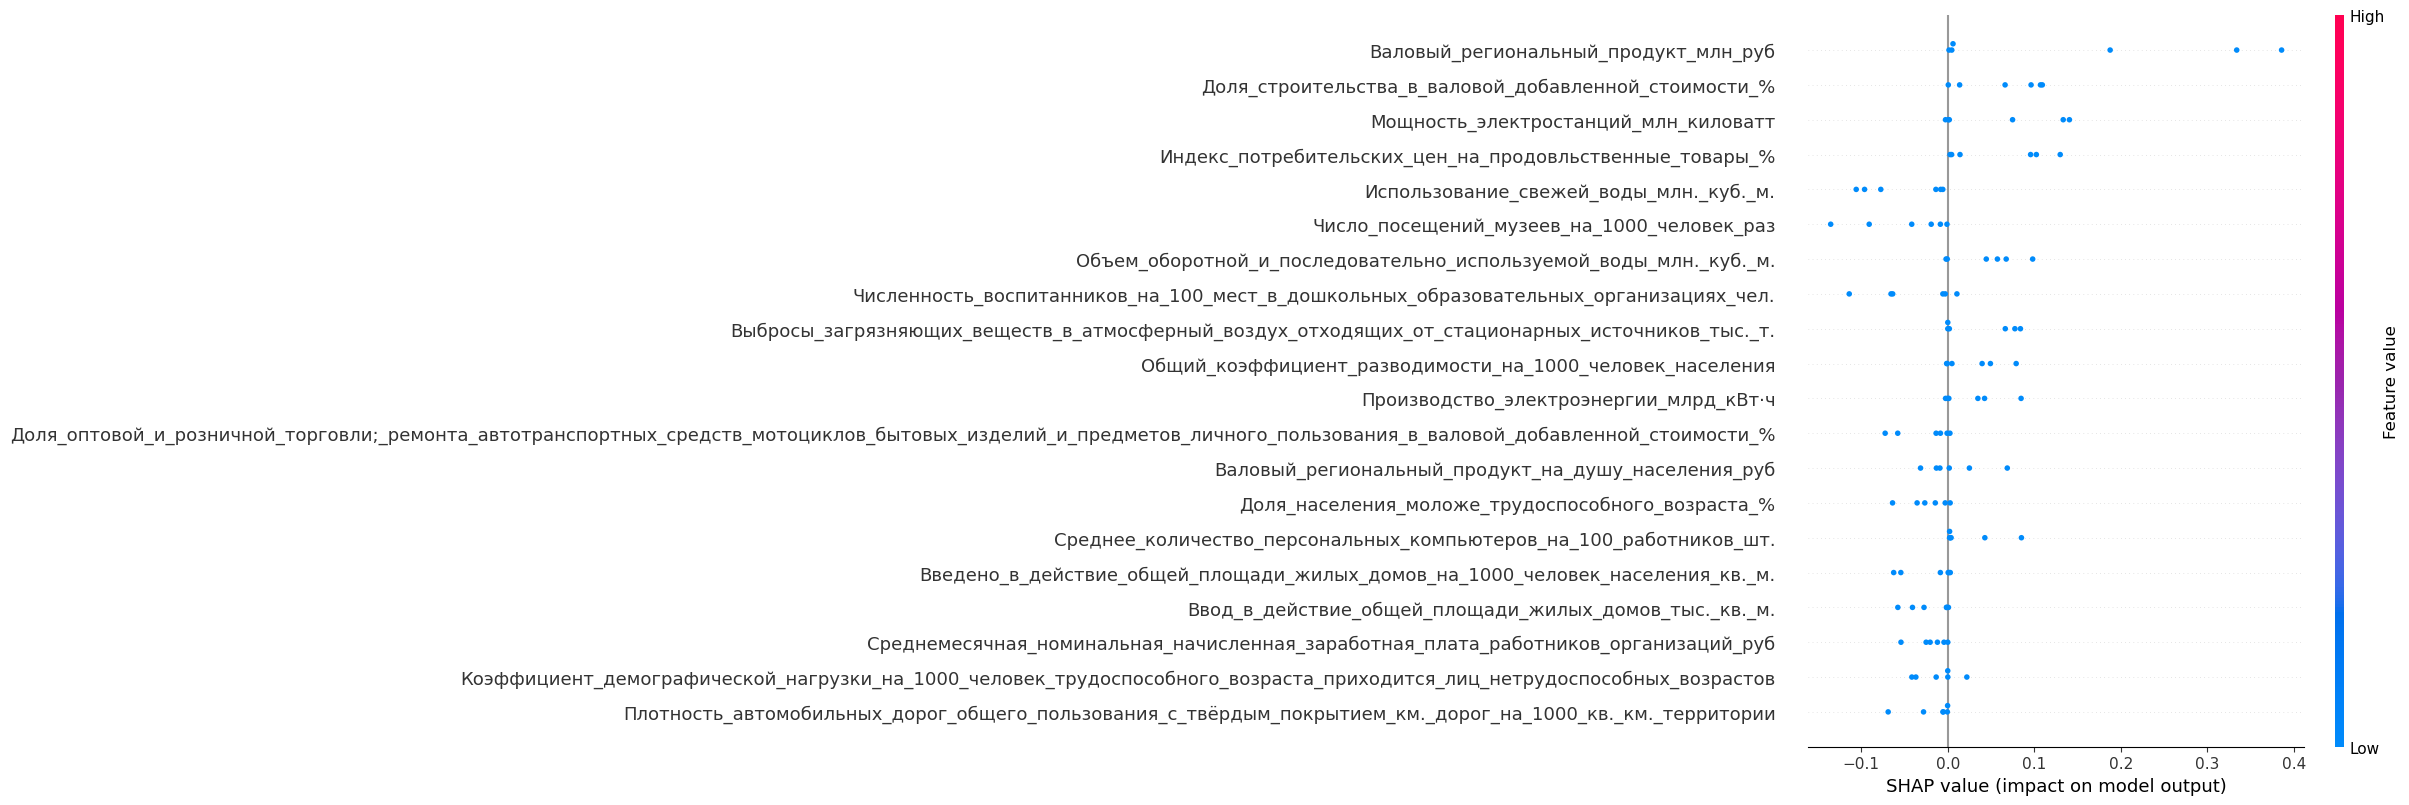

In [32]:
# Агрегация годовых колонок для обучающей и тестовой выборки
Xtr_agg = aggregate_years(X_train)
Xte_agg = aggregate_years(X_test)

# Обучение модели
best = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=100, max_depth=4, random_state=42))
best.fit(Xtr_agg, Y_train)

# Проводится SHAP-анализ в рамках каждого года и целевой переменной
sh_list = []
for est in best.estimators_:
    expl = shap.TreeExplainer(est)
    sh = expl.shap_values(Xte_agg)    
    sh_list.append(sh)

# Все массивы с SHAP-значениями объединяются в один
sh_arr = np.stack(sh_list, axis=0)    

# Построение графика SHAP-анализа
X_rep = pd.concat([Xte_agg]*len(sh_list), ignore_index=True)
sh_plot = sh_arr.reshape(-1, sh_arr.shape[2])
shap.summary_plot(sh_plot, X_rep, feature_names=Xte_agg.columns, show=False)
plt.tight_layout()

# SHAP-значения усредняются, заносятся в таблицу и исключаются незначимые факторы
mean_sh = sh_arr.mean(axis=(0,1))
imp = pd.DataFrame({
    "Фактор": Xte_agg.columns,
    "Важность": mean_sh})
imp = imp[imp["Важность"] != 0].sort_values("Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
imp.to_excel("SHAP-значимость факторов для Ключевых игроков 2025-2027 гг.xlsx", index=False)
FileLink("SHAP-значимость факторов для Ключевых игроков 2025-2027 гг.xlsx")

## Выбор модели МО перед SHAP-анализом для Потенциалов (НАО и Псковская область)

In [33]:
# Фиксируются анализируемые годы
years = [2025, 2026, 2027]

# Строится таблица с интересующими столбцами
df = df_forecast_pivot[['Регион', 'Показатель'] + years]
df_wide = df.pivot(index='Регион', columns='Показатель', values=years)

# Преобразуем названия колонок в вид {Показатель_Год}, что необходимо для корректной работы кода при анализе нескольких лет
new_cols = []
for year, metric in df_wide.columns.to_flat_index():
    clean = metric.replace(',', '').replace(' ', '_')
    new_cols.append(f"{clean}_{year}")
df_wide.columns = new_cols

# Названия признаков приводятся к виду колонок
pref1 = target_1.replace(',', '').replace(' ', '_')
pref2 = target_2.replace(',', '').replace(' ', '_')

# Определяются столбцы с целевыми переменными
t1_cols = [f"{pref1}_{y}" for y in years]
t2_cols = [f"{pref2}_{y}" for y in years]

# Остальные столбцы это независимые переменные
feature_cols = [c for c in df_wide.columns if c not in (t1_cols + t2_cols)]

# Таблица разделяется на матрицы признаков
X_all = df_wide[feature_cols]
Y_all = df_wide[t1_cols + t2_cols]

# Регионы для тестирования
test_regions = ["  в т.ч. Ненецкий авт. округ", "Псковская область"]

# Создаются модели МО
models = {
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)),
    "ExtraTrees": MultiOutputRegressor(ExtraTreesRegressor(n_estimators=250, max_depth=5, random_state=42))}

# Обучение, предсказывание, вывод метрик ошибок для каждого тестового региона
for region in test_regions:
    if region not in X_all.index:
        raise ValueError(f"Регион {region} не найден в данных.")
    X_train = X_all.drop(index=region)
    Y_train = Y_all.drop(index=region)
    X_test  = X_all.loc[[region]]
    Y_test  = Y_all.loc[[region]]

    print(f"Оценка качества для региона: {region}")
    for name, base in models.items():
        model = base
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test) 
        y_true = Y_test.iloc[0].to_numpy()
        y_pred = Y_pred.flatten()
        
        rmse, mae, smape = calculate_metrics(y_true, y_pred)
        print(f"  {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, SMAPE: {smape:.2f}%")

Оценка качества для региона:   в т.ч. Ненецкий авт. округ
  XGBoost - RMSE: 2.13, MAE: 1.98, SMAPE: 15.53%
  LightGBM - RMSE: 1.96, MAE: 1.90, SMAPE: 14.88%
  ExtraTrees - RMSE: 1.62, MAE: 1.48, SMAPE: 11.47%
Оценка качества для региона: Псковская область
  XGBoost - RMSE: 0.71, MAE: 0.60, SMAPE: 5.28%
  LightGBM - RMSE: 0.74, MAE: 0.73, SMAPE: 6.00%
  ExtraTrees - RMSE: 0.51, MAE: 0.37, SMAPE: 3.25%


## SHAP-анализ для 2025-2027 гг. для Потенциалов (НАО и Псковская область)

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\nikid\AppData\Local\Temp\ipykernel_12736\1111404743.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


C:\Users\nikid\SHAP-значимость факторов для Потенциалов 2025-2027 гг.xlsx

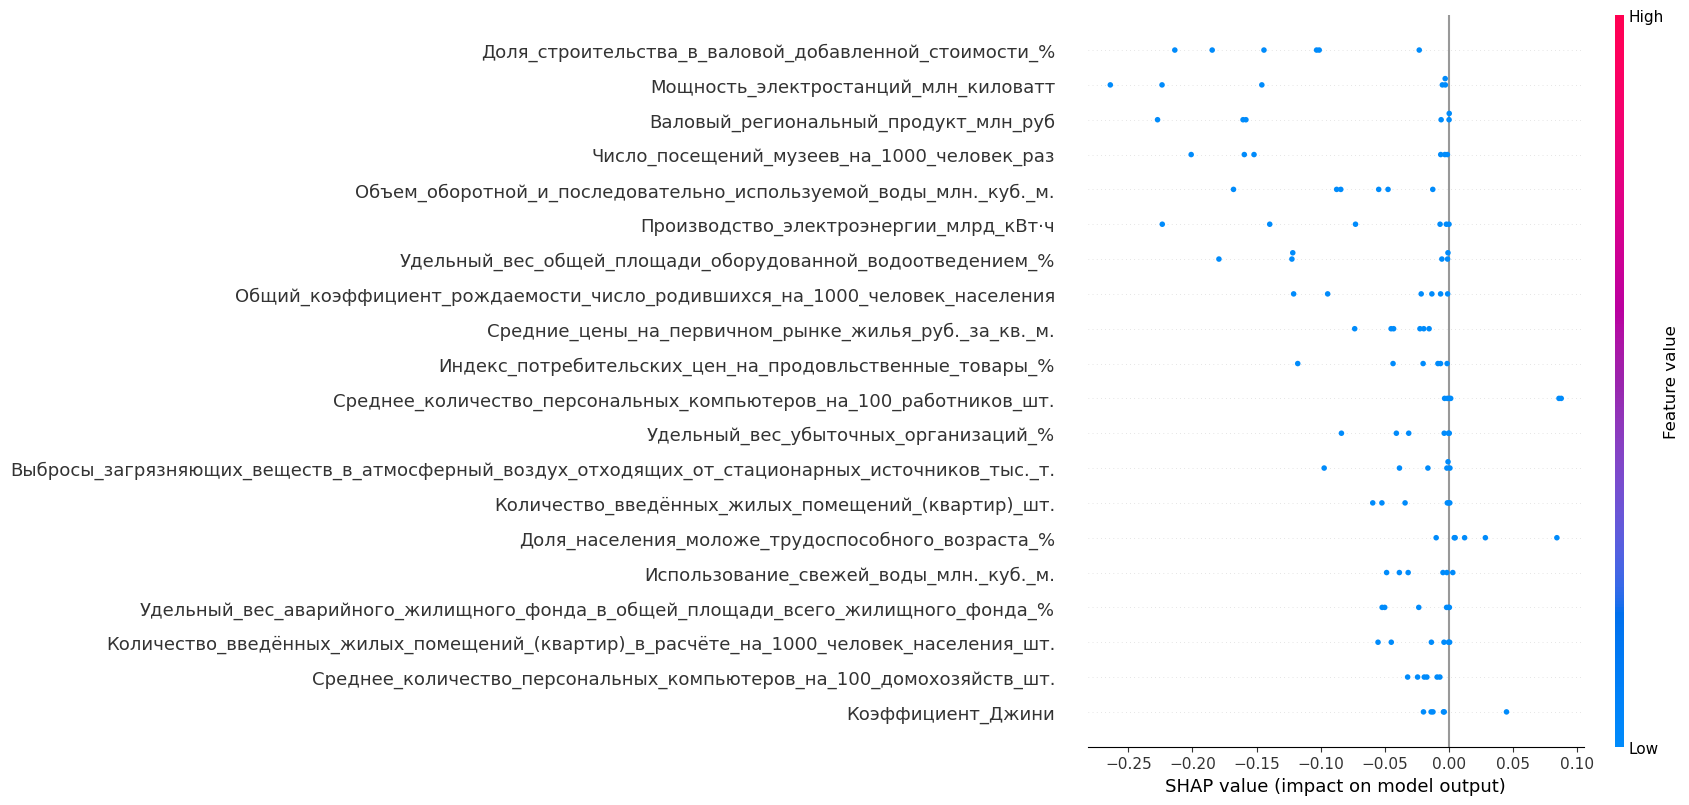

In [34]:
# Агрегация годовых колонок для обучающей и тестовой выборки
Xtr_agg = aggregate_years(X_train)
Xte_agg = aggregate_years(X_test)

# Обучение модели
best = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=250, max_depth=5, random_state=42))
best.fit(Xtr_agg, Y_train)

# Проводится SHAP-анализ в рамках каждого года и целевой переменной
sh_list = []
for est in best.estimators_:
    expl = shap.TreeExplainer(est)
    sh = expl.shap_values(Xte_agg)    
    sh_list.append(sh)

# Все массивы с SHAP-значениями объединяются в один
sh_arr = np.stack(sh_list, axis=0)    

# Построение графика SHAP-анализа
X_rep = pd.concat([Xte_agg]*len(sh_list), ignore_index=True)
sh_plot = sh_arr.reshape(-1, sh_arr.shape[2])
shap.summary_plot(sh_plot, X_rep, feature_names=Xte_agg.columns, show=False)
plt.tight_layout()

# SHAP-значения усредняются, заносятся в таблицу и исключаются незначимые факторы
mean_sh = sh_arr.mean(axis=(0,1))
imp = pd.DataFrame({
    "Фактор": Xte_agg.columns,
    "Важность": mean_sh})
imp = imp[imp["Важность"] != 0].sort_values("Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
imp.to_excel("SHAP-значимость факторов для Потенциалов 2025-2027 гг.xlsx", index=False)
FileLink("SHAP-значимость факторов для Потенциалов 2025-2027 гг.xlsx")

## Выбор модели МО перед SHAP-анализом для Зоны отложенного роста (Республики Коми и Карелия и АО без НАО)

In [35]:
# Фиксируются анализируемые годы
years = [2025, 2026, 2027]

# Строится таблица с интересующими столбцами
df = df_forecast_pivot[['Регион', 'Показатель'] + years]
df_wide = df.pivot(index='Регион', columns='Показатель', values=years)

# Преобразуем названия колонок в вид {Показатель_Год}, что необходимо для корректной работы кода при анализе нескольких лет
new_cols = []
for year, metric in df_wide.columns.to_flat_index():
    clean = metric.replace(',', '').replace(' ', '_')
    new_cols.append(f"{clean}_{year}")
df_wide.columns = new_cols

# Названия признаков приводятся к виду колонок
pref1 = target_1.replace(',', '').replace(' ', '_')
pref2 = target_2.replace(',', '').replace(' ', '_')

# Определяются столбцы с целевыми переменными
t1_cols = [f"{pref1}_{y}" for y in years]
t2_cols = [f"{pref2}_{y}" for y in years]

# Остальные столбцы это независимые переменные
feature_cols = [c for c in df_wide.columns if c not in (t1_cols + t2_cols)]

# Таблица разделяется на матрицы признаков
X_all = df_wide[feature_cols]
Y_all = df_wide[t1_cols + t2_cols]

# Регионы для тестирования
test_regions = ["Республика Карелия", "Республика Коми", "  Архангельская область без Ненецкого авт.округа"]

# Создаются модели МО
models = {
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)),
    "ExtraTrees": MultiOutputRegressor(ExtraTreesRegressor(n_estimators=150, max_depth=7, random_state=42))}

# Обучение, предсказывание, вывод метрик ошибок для каждого тестового региона
for region in test_regions:
    if region not in X_all.index:
        raise ValueError(f"Регион {region} не найден в данных.")
    X_train = X_all.drop(index=region)
    Y_train = Y_all.drop(index=region)
    X_test  = X_all.loc[[region]]
    Y_test  = Y_all.loc[[region]]

    print(f"Оценка качества для региона: {region}")
    for name, base in models.items():
        model = base
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test) 
        y_true = Y_test.iloc[0].to_numpy()
        y_pred = Y_pred.flatten()
        
        rmse, mae, smape = calculate_metrics(y_true, y_pred)
        print(f"  {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, SMAPE: {smape:.2f}%")

Оценка качества для региона: Республика Карелия
  XGBoost - RMSE: 0.46, MAE: 0.41, SMAPE: 3.59%
  LightGBM - RMSE: 1.24, MAE: 1.02, SMAPE: 8.68%
  ExtraTrees - RMSE: 1.09, MAE: 0.84, SMAPE: 7.22%
Оценка качества для региона: Республика Коми
  XGBoost - RMSE: 1.02, MAE: 0.98, SMAPE: 7.30%
  LightGBM - RMSE: 1.09, MAE: 0.93, SMAPE: 7.22%
  ExtraTrees - RMSE: 0.42, MAE: 0.35, SMAPE: 2.61%
Оценка качества для региона:   Архангельская область без Ненецкого авт.округа
  XGBoost - RMSE: 0.46, MAE: 0.41, SMAPE: 3.66%
  LightGBM - RMSE: 1.16, MAE: 1.08, SMAPE: 9.09%
  ExtraTrees - RMSE: 0.62, MAE: 0.49, SMAPE: 4.25%


## SHAP-анализ для 2025-2027 гг. для для Зоны отложенного роста (Республики Коми и Карелия и АО без НАО)

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\nikid\AppData\Local\Temp\ipykernel_12736\87265496.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


C:\Users\nikid\SHAP-значимость факторов для Зоны отложенного роста 2025-2027 гг.xlsx

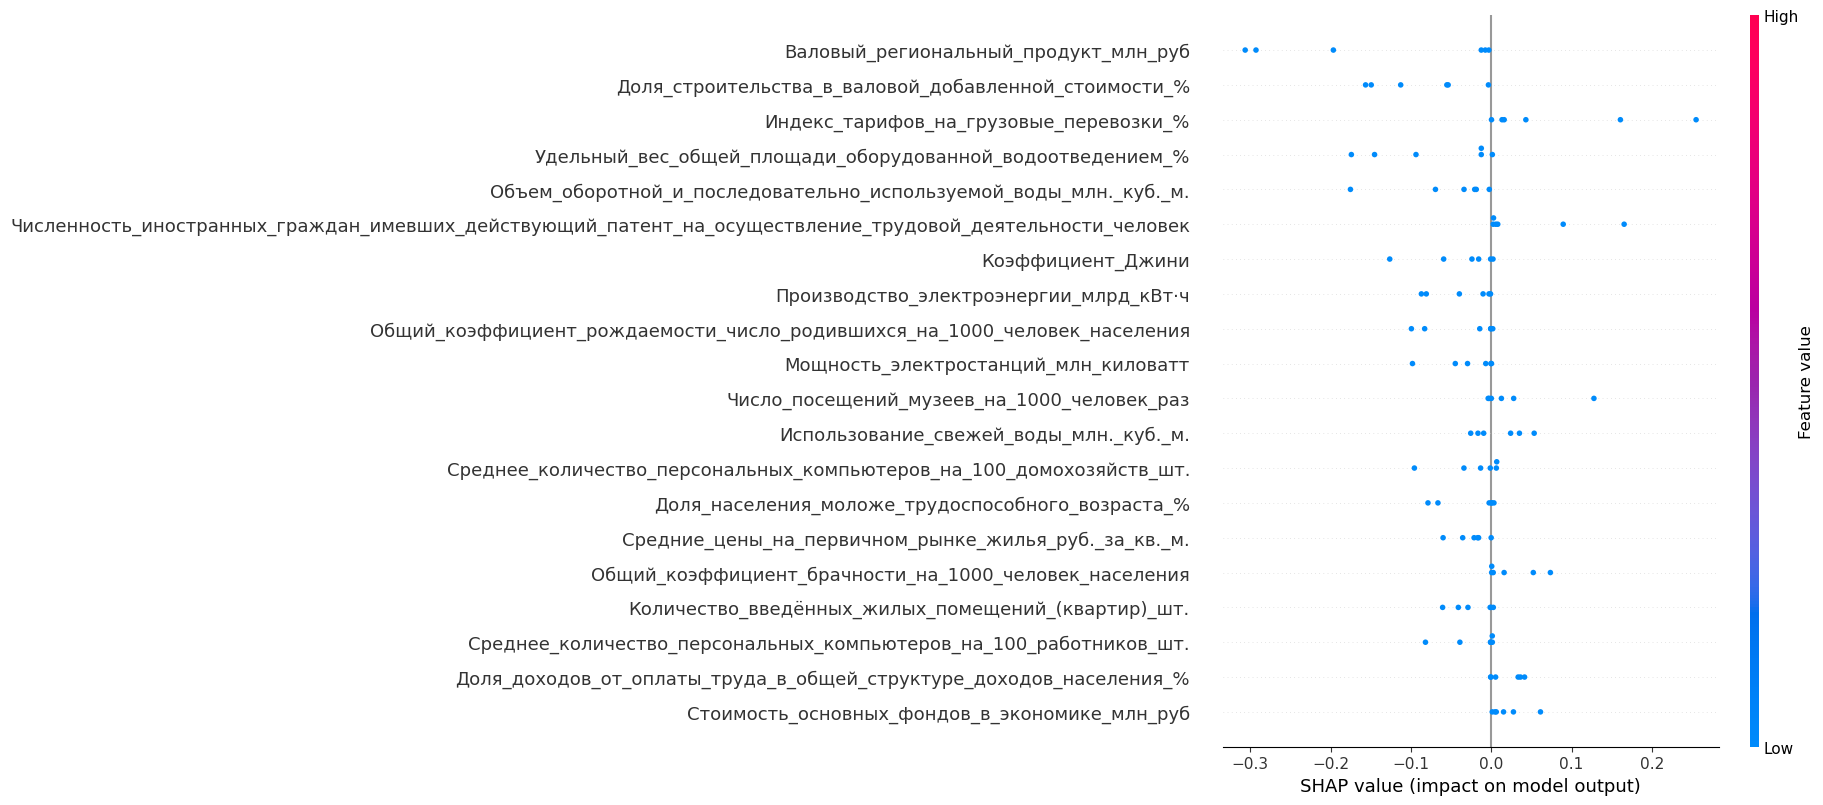

In [36]:
# Агрегация годовых колонок для обучающей и тестовой выборки
Xtr_agg = aggregate_years(X_train)
Xte_agg = aggregate_years(X_test)

# Обучение модели
best = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=150, max_depth=7, random_state=42))
best.fit(Xtr_agg, Y_train)

# Проводится SHAP-анализ в рамках каждого года и целевой переменной
sh_list = []
for est in best.estimators_:
    expl = shap.TreeExplainer(est)
    sh = expl.shap_values(Xte_agg)    
    sh_list.append(sh)

# Все массивы с SHAP-значениями объединяются в один
sh_arr = np.stack(sh_list, axis=0)    

# Построение графика SHAP-анализа
X_rep = pd.concat([Xte_agg]*len(sh_list), ignore_index=True)
sh_plot = sh_arr.reshape(-1, sh_arr.shape[2])
shap.summary_plot(sh_plot, X_rep, feature_names=Xte_agg.columns, show=False)
plt.tight_layout()

# SHAP-значения усредняются, заносятся в таблицу и исключаются незначимые факторы
mean_sh = sh_arr.mean(axis=(0,1))
imp = pd.DataFrame({
    "Фактор": Xte_agg.columns,
    "Важность": mean_sh})
imp = imp[imp["Важность"] != 0].sort_values("Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
imp.to_excel("SHAP-значимость факторов для Зоны отложенного роста 2025-2027 гг.xlsx", index=False)
FileLink("SHAP-значимость факторов для Зоны отложенного роста 2025-2027 гг.xlsx")

## Выбор модели МО перед SHAP-анализом для Аутсайдеров (Калининградская и Архангельская области)

In [37]:
# Фиксируются анализируемые годы
years = [2025, 2026, 2027]

# Строится таблица с интересующими столбцами
df = df_forecast_pivot[['Регион', 'Показатель'] + years]
df_wide = df.pivot(index='Регион', columns='Показатель', values=years)

# Преобразуем названия колонок в вид {Показатель_Год}, что необходимо для корректной работы кода при анализе нескольких лет
new_cols = []
for year, metric in df_wide.columns.to_flat_index():
    clean = metric.replace(',', '').replace(' ', '_')
    new_cols.append(f"{clean}_{year}")
df_wide.columns = new_cols

# Названия признаков приводятся к виду колонок
pref1 = target_1.replace(',', '').replace(' ', '_')
pref2 = target_2.replace(',', '').replace(' ', '_')

# Определяются столбцы с целевыми переменными
t1_cols = [f"{pref1}_{y}" for y in years]
t2_cols = [f"{pref2}_{y}" for y in years]

# Остальные столбцы это независимые переменные
feature_cols = [c for c in df_wide.columns if c not in (t1_cols + t2_cols)]

# Таблица разделяется на матрицы признаков
X_all = df_wide[feature_cols]
Y_all = df_wide[t1_cols + t2_cols]

# Регионы для тестирования
test_regions = ["Калининградская область", "Архангельская область"]

# Создаются модели МО
models = {
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=100, max_depth=2, random_state=42, verbose=-1)),
    "ExtraTrees": MultiOutputRegressor(ExtraTreesRegressor(n_estimators=150, max_depth=3, random_state=42))}

# Обучение, предсказывание, вывод метрик ошибок для каждого тестового региона
for region in test_regions:
    if region not in X_all.index:
        raise ValueError(f"Регион {region} не найден в данных.")
    X_train = X_all.drop(index=region)
    Y_train = Y_all.drop(index=region)
    X_test  = X_all.loc[[region]]
    Y_test  = Y_all.loc[[region]]

    print(f"Оценка качества для региона: {region}")
    for name, base in models.items():
        model = base
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test) 
        y_true = Y_test.iloc[0].to_numpy()
        y_pred = Y_pred.flatten()
        
        rmse, mae, smape = calculate_metrics(y_true, y_pred)
        print(f"  {name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, SMAPE: {smape:.2f}%")

Оценка качества для региона: Калининградская область
  XGBoost - RMSE: 0.29, MAE: 0.23, SMAPE: 2.10%
  LightGBM - RMSE: 1.44, MAE: 1.40, SMAPE: 11.87%
  ExtraTrees - RMSE: 0.88, MAE: 0.86, SMAPE: 7.44%
Оценка качества для региона: Архангельская область
  XGBoost - RMSE: 0.87, MAE: 0.82, SMAPE: 6.36%
  LightGBM - RMSE: 0.25, MAE: 0.21, SMAPE: 1.70%
  ExtraTrees - RMSE: 0.28, MAE: 0.22, SMAPE: 1.77%


## SHAP-анализ для 2025-2027 гг. для Аутсайдеров (Калининградская и Архангельская области)

D:\Anaconda\Lib\site-packages\shap\plots\_beeswarm.py:1145: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()
C:\Users\nikid\AppData\Local\Temp\ipykernel_12736\3195140583.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


C:\Users\nikid\SHAP-значимость факторов для Аутсайдеров 2025-2027 гг.xlsx

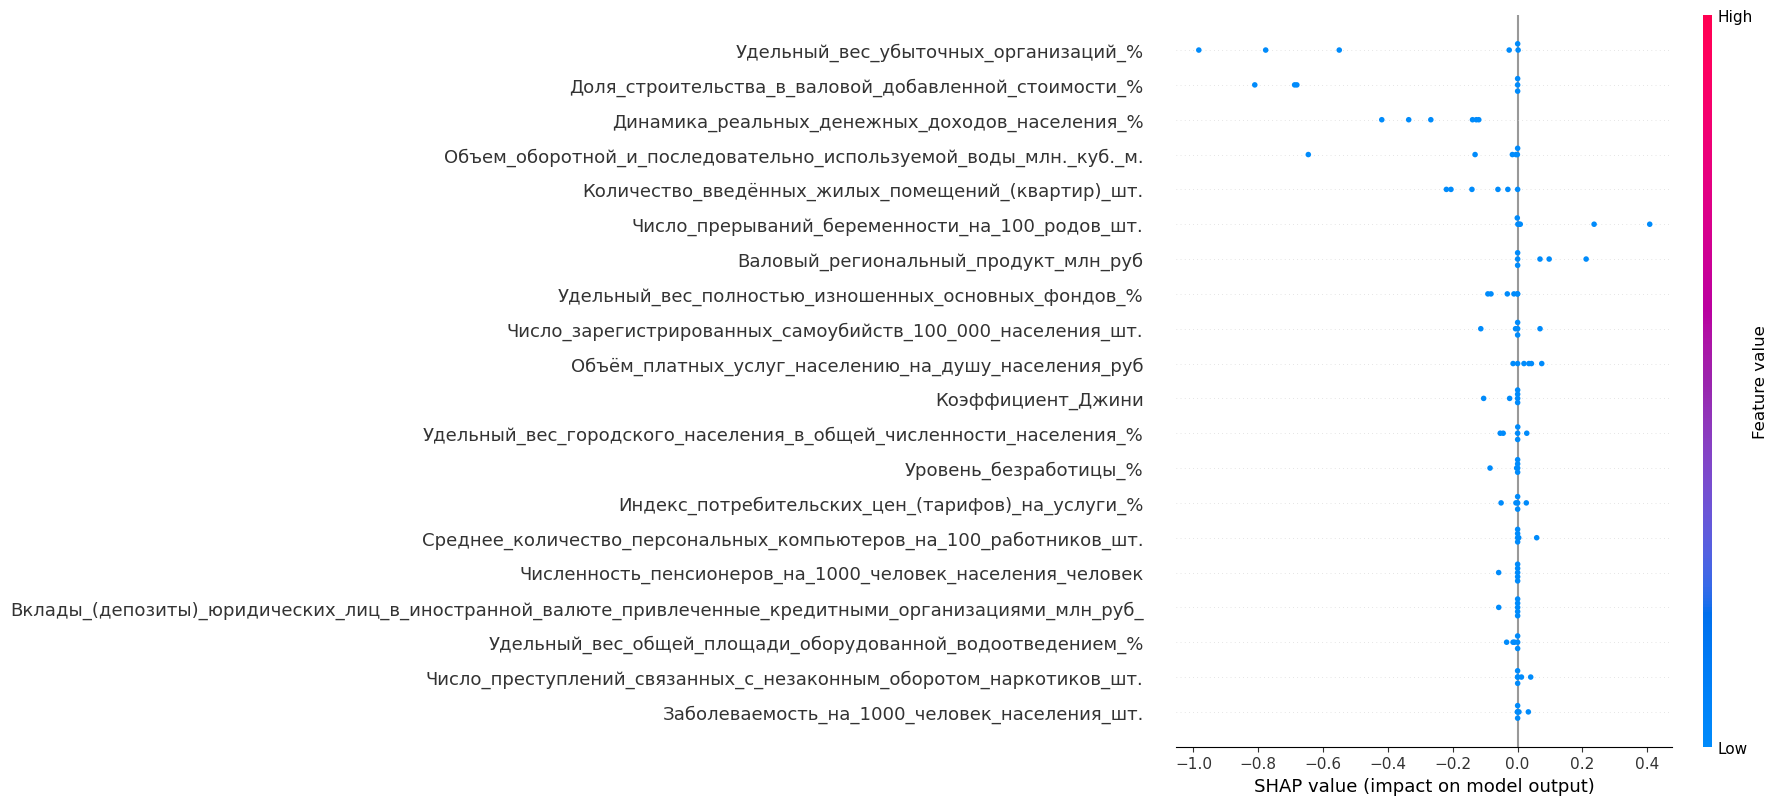

In [38]:
# Агрегация годовых колонок для обучающей и тестовой выборки
Xtr_agg = aggregate_years(X_train)
Xte_agg = aggregate_years(X_test)

# Обучение модели
best = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42))
best.fit(Xtr_agg, Y_train)

# Проводится SHAP-анализ в рамках каждого года и целевой переменной
sh_list = []
for est in best.estimators_:
    expl = shap.TreeExplainer(est)
    sh = expl.shap_values(Xte_agg)    
    sh_list.append(sh)

# Все массивы с SHAP-значениями объединяются в один
sh_arr = np.stack(sh_list, axis=0)    

# Построение графика SHAP-анализа
X_rep = pd.concat([Xte_agg]*len(sh_list), ignore_index=True)
sh_plot = sh_arr.reshape(-1, sh_arr.shape[2])
shap.summary_plot(sh_plot, X_rep, feature_names=Xte_agg.columns, show=False)
plt.tight_layout()

# SHAP-значения усредняются, заносятся в таблицу и исключаются незначимые факторы
mean_sh = sh_arr.mean(axis=(0,1))
imp = pd.DataFrame({
    "Фактор": Xte_agg.columns,
    "Важность": mean_sh})
imp = imp[imp["Важность"] != 0].sort_values("Важность", ascending=False)

# Сохранение SHAP-значимости в Excel
imp.to_excel("SHAP-значимость факторов для Аутсайдеров 2025-2027 гг.xlsx", index=False)
FileLink("SHAP-значимость факторов для Аутсайдеров 2025-2027 гг.xlsx")

# Создание сводной таблицы со всеми данным в оригинальном масштабе

In [39]:
# Числовые столбцы годов в df_forecast_pivot переименовываются в строковые, чтобы они совпали с df_l
df_forecast_pivot = df_forecast_pivot.rename(columns={year: str(year) for year in range(2023, 2028)})

# df_1 и df_forecast_pivot объединяются по "Регион" и "Показатель"
df_merged = pd.merge(df_l, df_forecast_pivot, on=["Регион", "Показатель"], how="left")

# Упорядочивание столбцов
year_cols = [str(y) for y in range(2010, 2028)]
df_merged = df_merged[["Регион", "Показатель"] + year_cols]

# Инвертирование логарифмирования
df_merged[year_cols] = np.expm1(df_merged[year_cols])

# Сохранение результата в Excel
df_merged.to_excel("Социально-экономические показатели регионов СЗФО 2010 - 2027 г.xlsx", index=False)
FileLink("Социально-экономические показатели регионов СЗФО 2010 - 2027 г.xlsx")

C:\Users\nikid\Социально-экономические показатели регионов СЗФО 2010 - 2027 г.xlsx